In [277]:
%load_ext autoreload
%autoreload 2
import numpy as np
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import matplotlib.pylab as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from torch.utils.data import DataLoader,ConcatDataset, TensorDataset
import torchvision
import matplotlib.patches as patches
import torchvision.transforms as transforms

import os
import time
import torch
import sys
import argparse
sys.path.insert(0, '../../shared_code')
# from network import *
from model_loader_func import * 
from dataloader_func import resize_image,add_noise_torch, rescale_image_range,int_to_float,rgb_to_gray, patch_generator, single_image_loader,load_dataset,prep_dataset
from quality_metrics_func import *
from linear_approx import *
from inverse_tasks_func import synthesis
from plotting_func import plot_many_denoised,  show_im_set, plot_single_im,plot_matching_patches
from algorithm_inv_prob import * 
from trainer import make_loader
from synthetic_data_generators import *

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [199]:
print(torch.__version__)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

2.5.0+cu124


device(type='cuda')

## Load denoisers


In [4]:
denoisers = {}


root_path = '/mnt/home/zkadkhodaie/ceph/21_hierarchical_conditional_prior/denoisers/'

paths = { 'mixture-gray':'UNet_flex/ovals/0to255_RF_172x172_set_size_100000_gray_5_classes_160x160/',           
            'conditional-gray':'UNet_conditional_mean_matching/ovals/0to255_RF_172x172_set_size_100000_gray_5_classes_160x160/'
        }

groups = paths.keys()

for group in groups: 
    path = root_path + paths[group]

    print('loading group ' , group )
    denoisers[group] = load_learned_model(path, print_args=True)
    start_time_total = time.time()        
    print("--- %s seconds ---" % (round(time.time() - start_time_total)))
     
    

loading group  mixture-gray
*************** saved arguments:*************
arch_name UNet_flex
lr 0.001
batch_size 512
num_epochs 1000
lr_freq 100
loss_weight False
noise_level_range [0, 255]
quadratic_noise True
rescale False
swap False
set_size 100000
imagenet_subset_ids None
self_cond False
data_name ovals
data_root_path /mnt/home/zkadkhodaie/ceph/datasets/
dir_name /mnt/home/zkadkhodaie/ceph/21_hierarchical_conditional_prior/denoisers/UNet_flex/ovals/0to255_RF_172x172_set_size_100000_gray_5_classes_160x160
optional_dir_label gray_5_classes
device cuda
debug False
kernel_size 3
padding 1
skip True
num_channels 1
bias True
RF 172
coarse True
num_kernels [16, 32, 64, 128, 256]
num_blocks 4
num_enc_conv [2, 2, 2, 2]
num_mid_conv 3
num_dec_conv [2, 2, 2, 2]
NormType LayerNorm
match_only_mid True
nonlinear_enc True
******************************************************
number of parameters is  2530385
train mode: False
--- 0 seconds ---
loading group  conditional-gray
*************** save

In [5]:
denoisers.keys()

dict_keys(['mixture-gray', 'conditional-gray'])

In [6]:
blocks = ['enc0','enc1', 'enc2','enc3','mid','dec3', 'dec2', 'dec1']

denoisers['mixture-gray'].save_means

False

# Make datasets 

In [7]:
def make_oval_dataset(set_size, aspect_ratios ): 
    # train 
    N = int(set_size/len(aspect_ratios))

    all_data_train = []
    for aspect_ratio in aspect_ratios:
        data = oval_dataset(N, aspect_ratio=aspect_ratio, W=160, H=160).to(device)
        all_data_train.append(data)
    
    #test 
    all_data_test = []
    for aspect_ratio in aspect_ratios:
        data = oval_dataset(N = 100, aspect_ratio=aspect_ratio, W=160, H=160).to(device)
        all_data_test.append(data)
        
    return all_data_train, all_data_test

In [8]:
train_sets, test_sets = make_oval_dataset(1000, [.2,.5,1,2,5])

In [9]:
print('number of images in each class:', train_sets[0].shape)
K = train_sets[0].shape[2]
n_channels = train_sets[0].shape[1]
print(len(train_sets))

number of images in each class: torch.Size([200, 1, 160, 160])
5


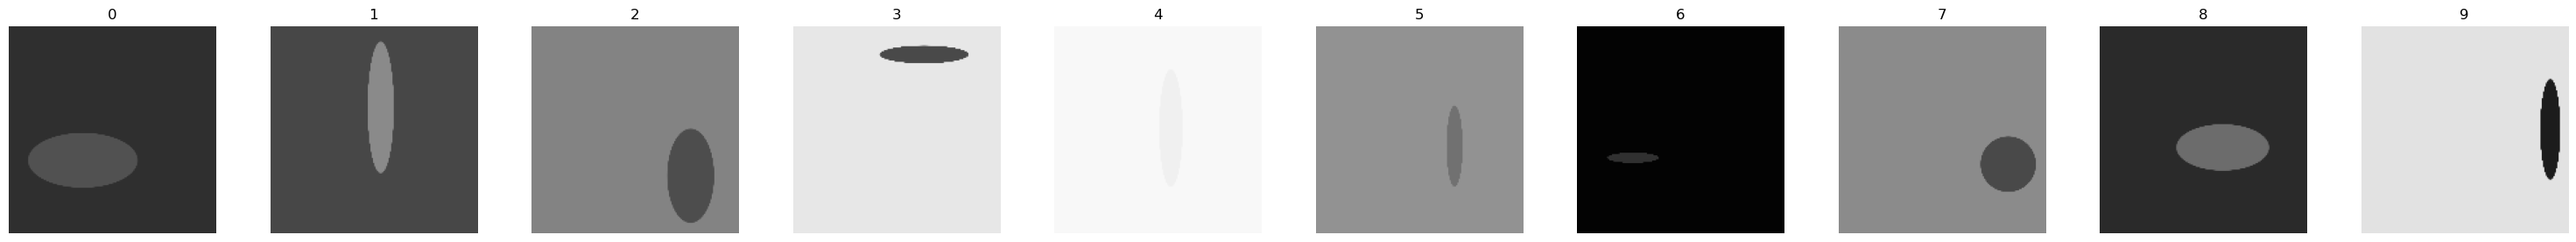

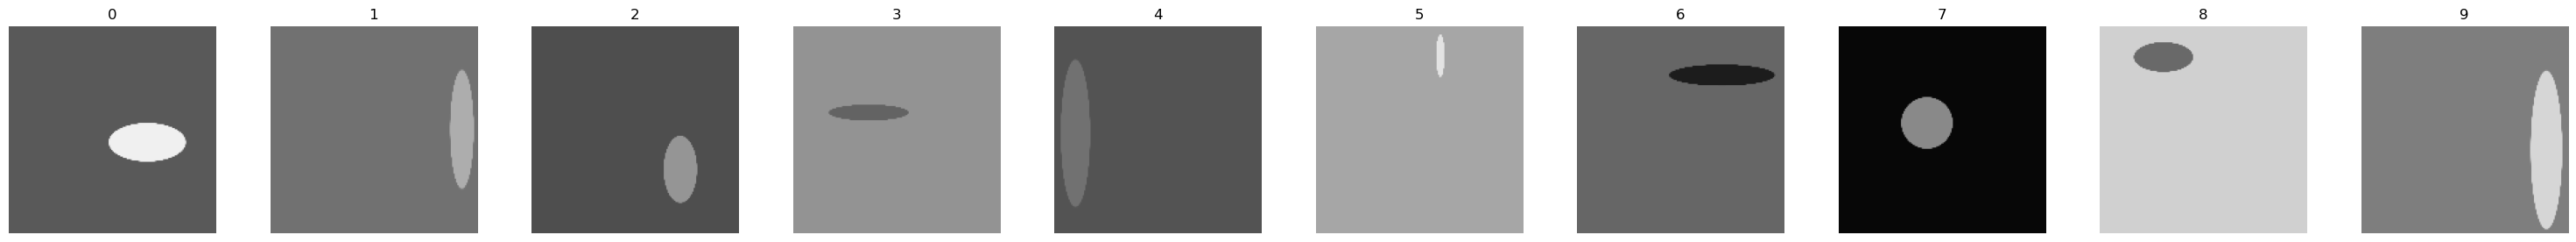

total number of train images: 1000


In [10]:
## shuffle train and test images and put them in one tensor 
loader, loader_cond = make_loader(dataset=train_sets, batch_size=512, dataset_cond=train_sets, self_cond =False)    
train ={}
train['inp']  = loader.dataset
train['cond'] = loader_cond.dataset
show_im_set(train['inp'][0:10], n_columns=10, vmin=0, vmax = 1)
show_im_set(train['cond'][0:10], n_columns=10, vmin=0, vmax = 1 )
print('total number of train images:',train['inp'].shape[0])


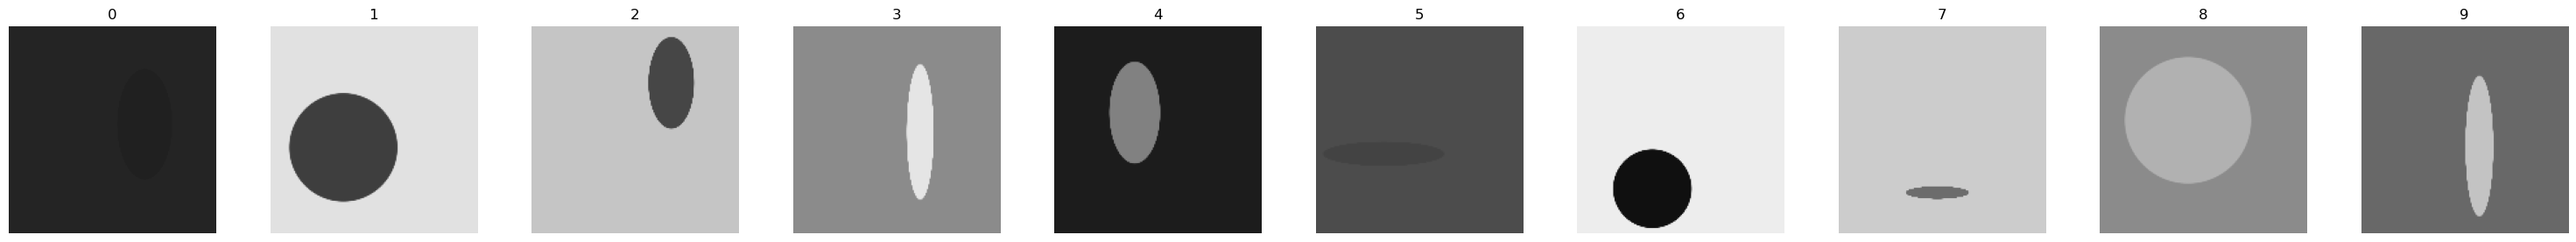

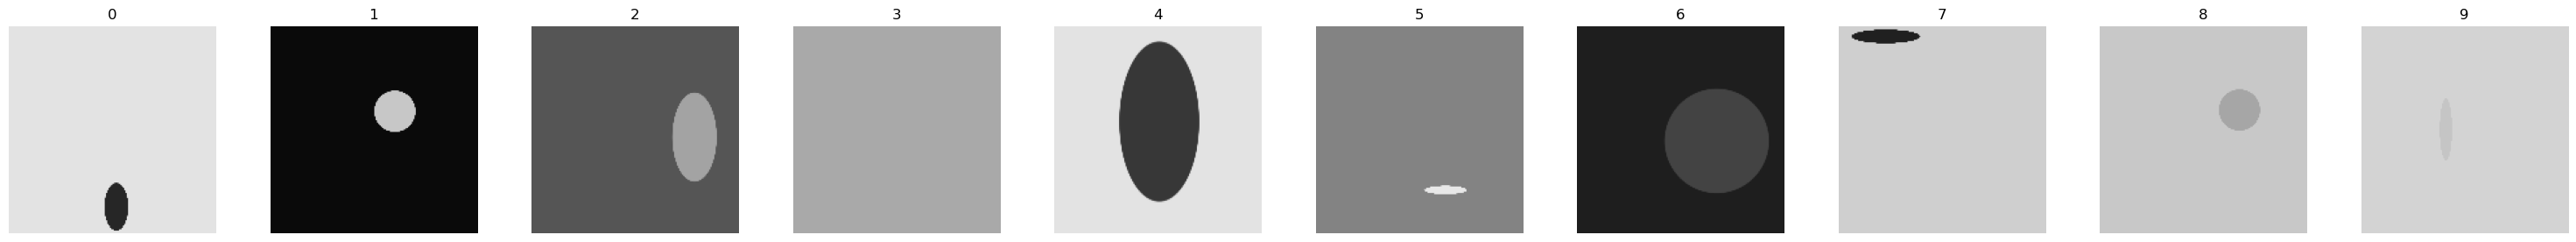

total number of test images: 500


In [11]:
loader, loader_cond = make_loader(dataset=test_sets, batch_size=256, dataset_cond=test_sets, self_cond =False)        
test ={}
test['inp']  = loader.dataset[0:1024]
test['cond'] = loader_cond.dataset[0:1024]
show_im_set(test['inp'][0:10], n_columns=10, vmin=0, vmax = 1)
show_im_set(test['cond'][0:10], n_columns=10, vmin=0, vmax = 1)
print('total number of test images:',test['inp'].shape[0])


tensor(0.4960, device='cuda:0')


160

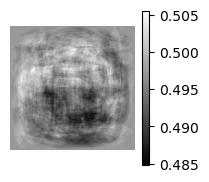

In [12]:
dist_mean = train['inp'].mean(0)
plot_single_im(dist_mean, colorbar=True)
print(dist_mean.mean())
K = dist_mean.shape[2]
K

# auxilary functions 

In [13]:
def get_channel_means(unet, im_cond, device=device, average_phi=False, with_params=True, return_activations = False): 
    '''
    returns means of channels of a UNet_flex operating on noisy
    @noisy: of shape N,C,H,W
    @with_param: important: set to False if phi is computed to be given to the network (instead of x)
    '''    

    unet.save_means = True    
    if return_activations: 
        unet.save_activations = True
        
    with torch.no_grad():
        try: 
            out = unet(im_cond.to(device), im_cond.to(device), average_phi)
            x_c_means = unet.stored_x_c_means
            x_c = unet.stored_x_c
            
        except TypeError: # for the unconditionaa model
            out = unet(im_cond.to(device))
            x_c_means = unet.stored_x_c_means
            x_c = unet.stored_x_c
            if average_phi: 
                for i in range(len(x_c_means)): 
                    x_c_means[i] = x_c_means[i].mean(0,keepdim=True)
            
    
    unet.save_means = False
    unet.save_activations = False


    if with_params:   
        try:
            params = get_matching_params(unet)
            for i in range(len(params)): 
                x_c_means[i] = x_c_means[i] * params[i]
        except AttributeError: 
            pass

    if return_activations: 
        return x_c_means, x_c
    else: 
        return x_c_means


        

def get_matching_params(unet): 
    params = []
    for l in range(len(unet.encoder_matching_params)):
        params.append(unet.encoder_matching_params[str(l)].detach().to(device))
    params.append(unet.mid_matching_params.detach().to(device))
    for l in range(len(unet.decoder_matching_params)-1, 0,-1):
        params.append(unet.decoder_matching_params[str(l)].detach().to(device))
    return params

# Synthesis from mixture model

In [18]:
groups


dict_keys(['mixture-gray', 'conditional-gray'])

In [19]:
# init image mean set ot category mean. What's its effetc?

n_samples =30

seed = 0
freq =100
sig_L = .1
h0= .01
beta = .1

fixed_h =True
all_samples = {}
all_interm_Ys = {}
all_init = []

start_time_total = time.time()

for group in ['mixture-gray']: 
    if seed is not None:
        torch.manual_seed(seed)
        

    
    print('--------- group : ', group)        
    all_samples[group] = {}
    all_interm_Ys[group] = {}            
    temp = []
    for _ in range(3):    
        if 'color' in group.split('-'): 
            n_channels = 3
            init_im = dist_mean.to(device)+ torch.randn(n_samples,n_channels ,K,K, device = device)        
            
        else: 
            n_channels = 1        
            # init_im = dist_mean.mean(dim=0,keepdim=True).to(device)+ torch.randn(n_samples,n_channels ,K,K, device = device)
            init_im = dist_mean.mean(dim=0,keepdim=True).to(device)+ torch.randn(n_samples,n_channels ,K,K, device = device)

        
        sample, interm_Ys,_, _ = batch_synthesis(denoisers[group],
                                              (n_samples,n_channels, K,K),
                                              init_im=init_im, 
                                              sig_0=1, 
                                              sig_L=sig_L, 
                                              h0=h0, 
                                              beta=beta, 
                                              freq=freq,
                                              device=device, 
                                              fixed_h = fixed_h,
                                              max_T=10000, 
                                              seed= seed
                                              )
                    
        temp.append(sample.detach())    
    
    all_samples[group] = torch.cat(temp)
    all_interm_Ys[group] = interm_Ys
    
            
print("--- %s seconds ---" % (time.time() - start_time_total))

--------- group :  mixture-gray
----------------------------- 100
sigma  0.775153636932373
mean  0.5077440142631531
----------------------------- 200
sigma  0.7021905779838562
mean  0.5083005428314209
----------------------------- 300
sigma  0.6359285116195679
mean  0.5071642398834229
----------------------------- 400
sigma  0.5746451616287231
mean  0.5089501142501831
----------------------------- 500
sigma  0.5203857421875
mean  0.5073705911636353
----------------------------- 600
sigma  0.47161874175071716
mean  0.5069282054901123
----------------------------- 700
sigma  0.4266534447669983
mean  0.5076876282691956
----------------------------- 800
sigma  0.3856859803199768
mean  0.5087116360664368
----------------------------- 900
sigma  0.34863272309303284
mean  0.509151041507721
----------------------------- 1000
sigma  0.314975768327713
mean  0.509469747543335
----------------------------- 1100
sigma  0.28530436754226685
mean  0.509389340877533
----------------------------- 1200
s

fixed_h= True  sig_L=  0.1  h0= 0.01  beta= 0.1  seed= 0  group= mixture-gray


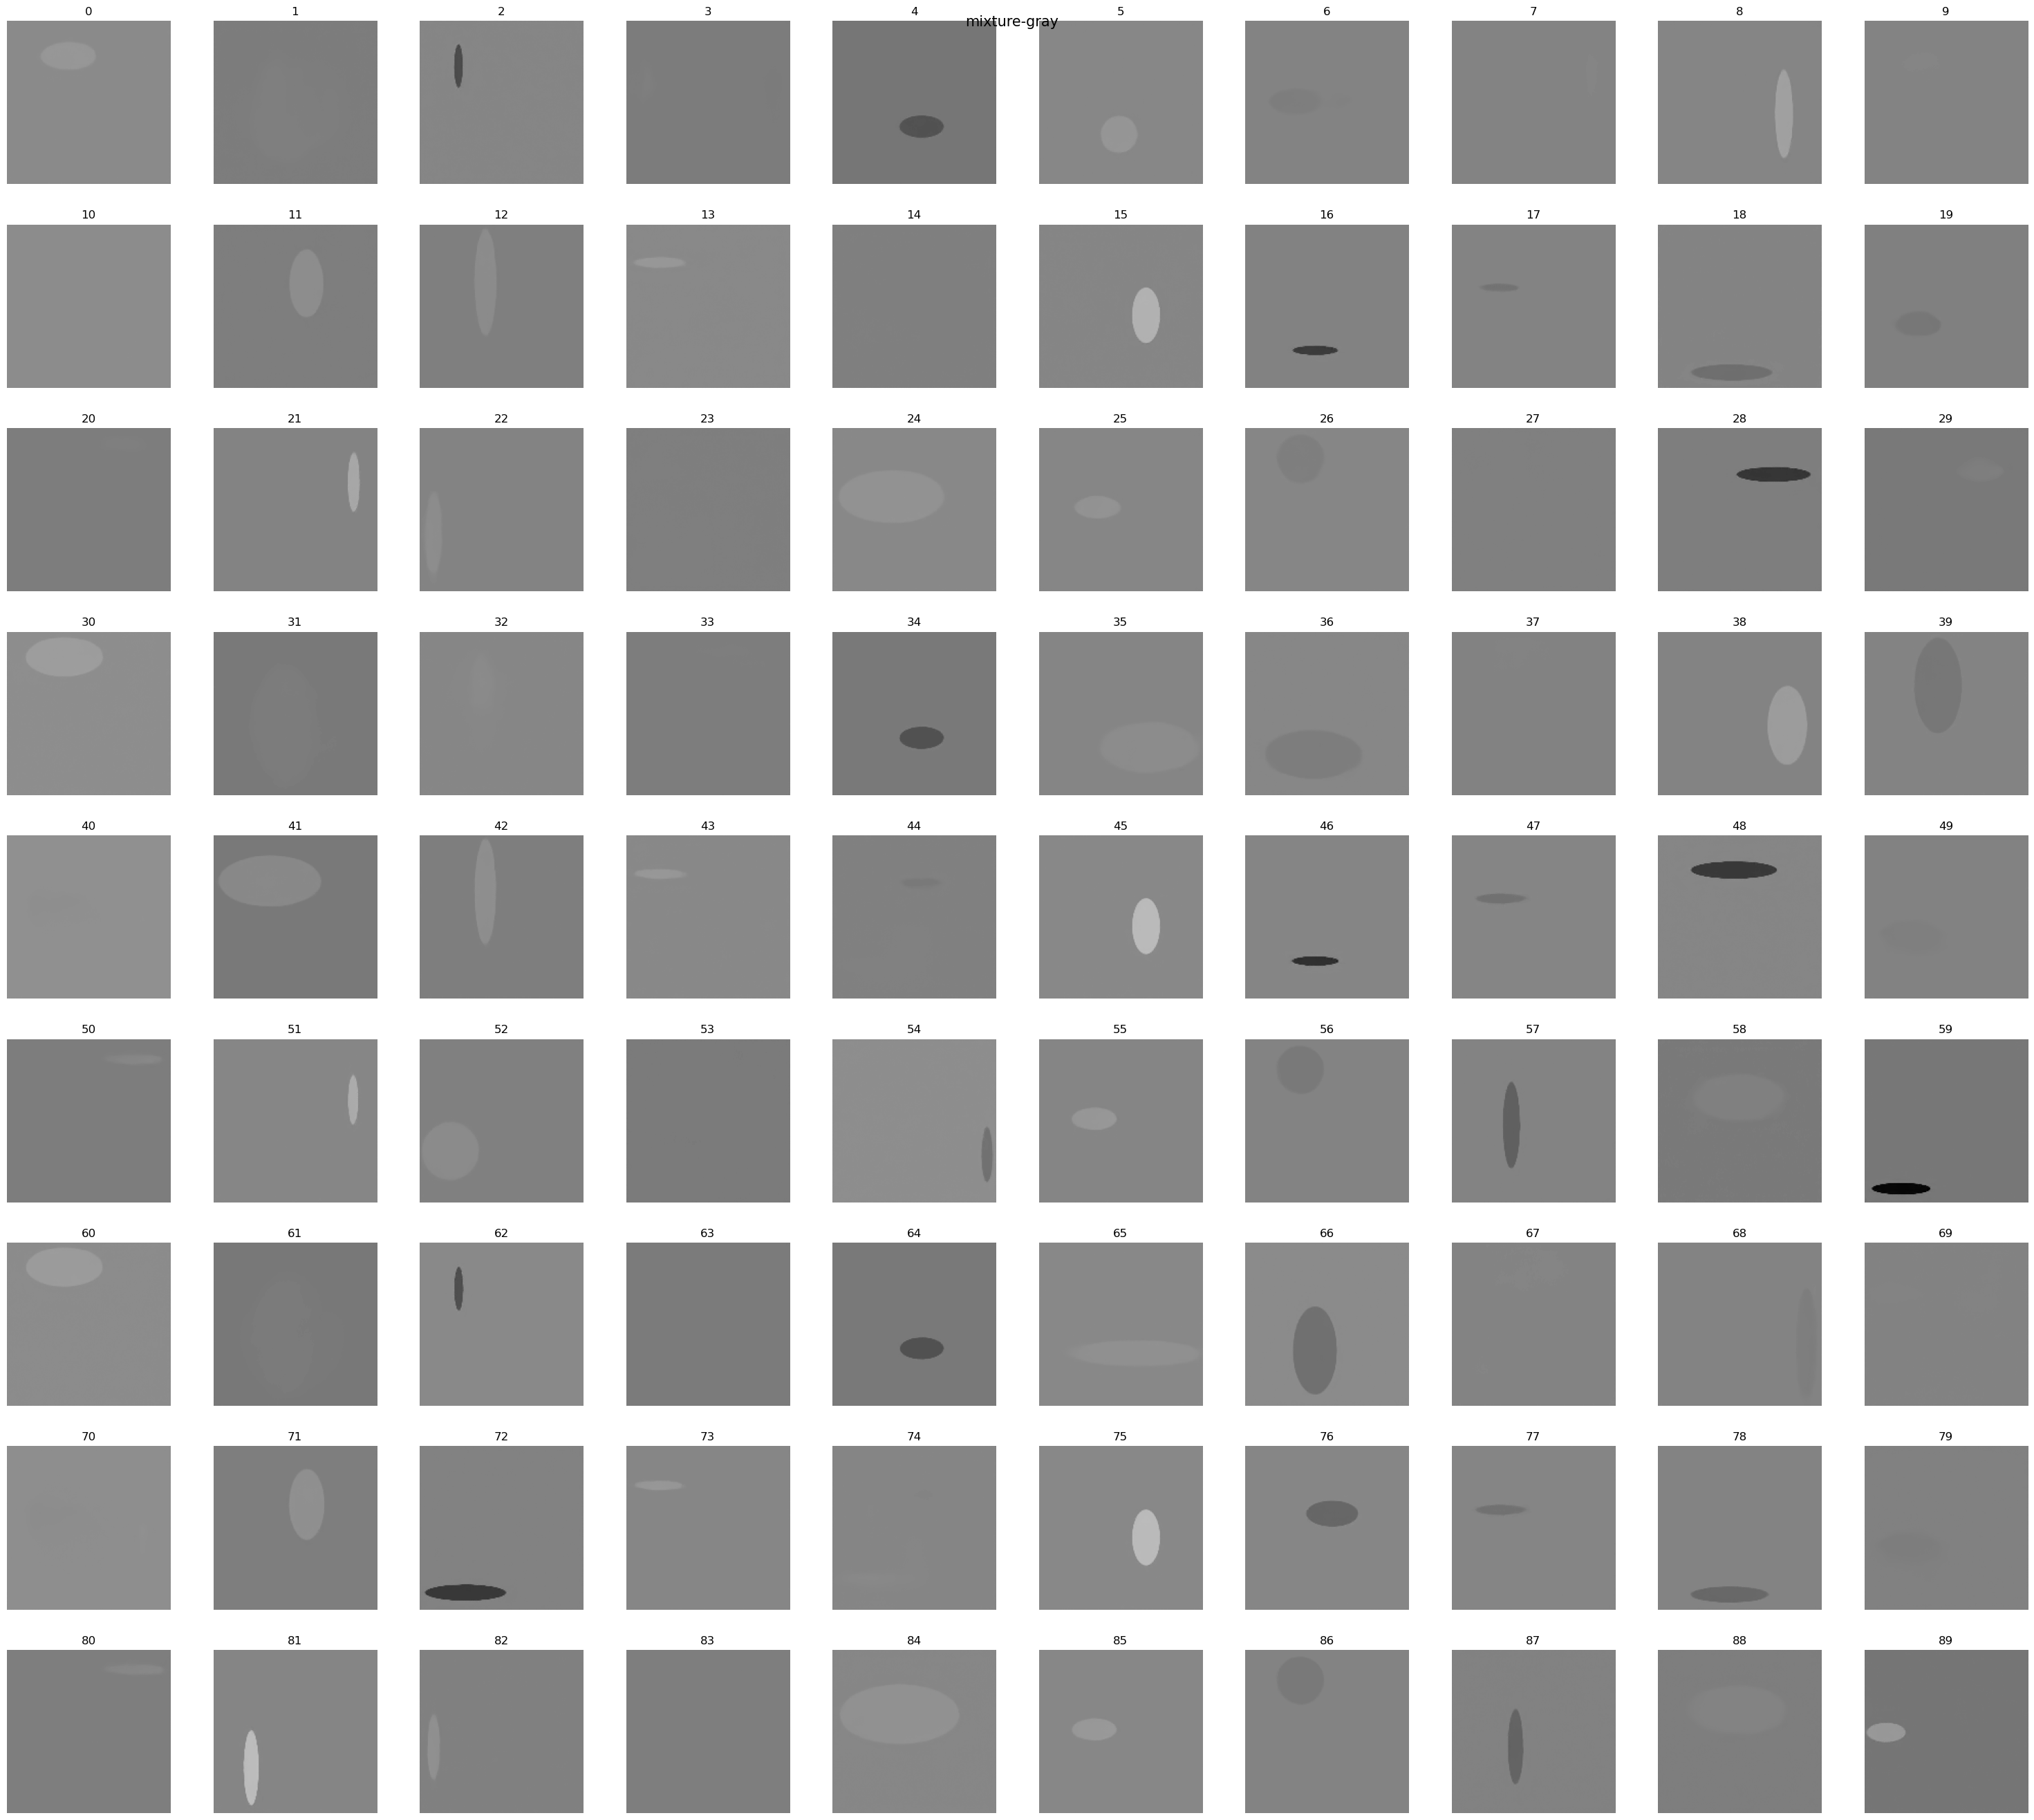

tensor(0.5120, device='cuda:0')


In [20]:
print('fixed_h=', fixed_h, ' sig_L= ',sig_L, ' h0=', h0, ' beta=',beta, ' seed=', seed, ' group=', group)
show_im_set(all_samples[group], n_columns=10, label=group, vmin=0, vmax = 1)

print(all_samples[group].mean())

fixed_h= True  sig_L=  0.1  h0= 0.01  beta= 0.1  seed= 0


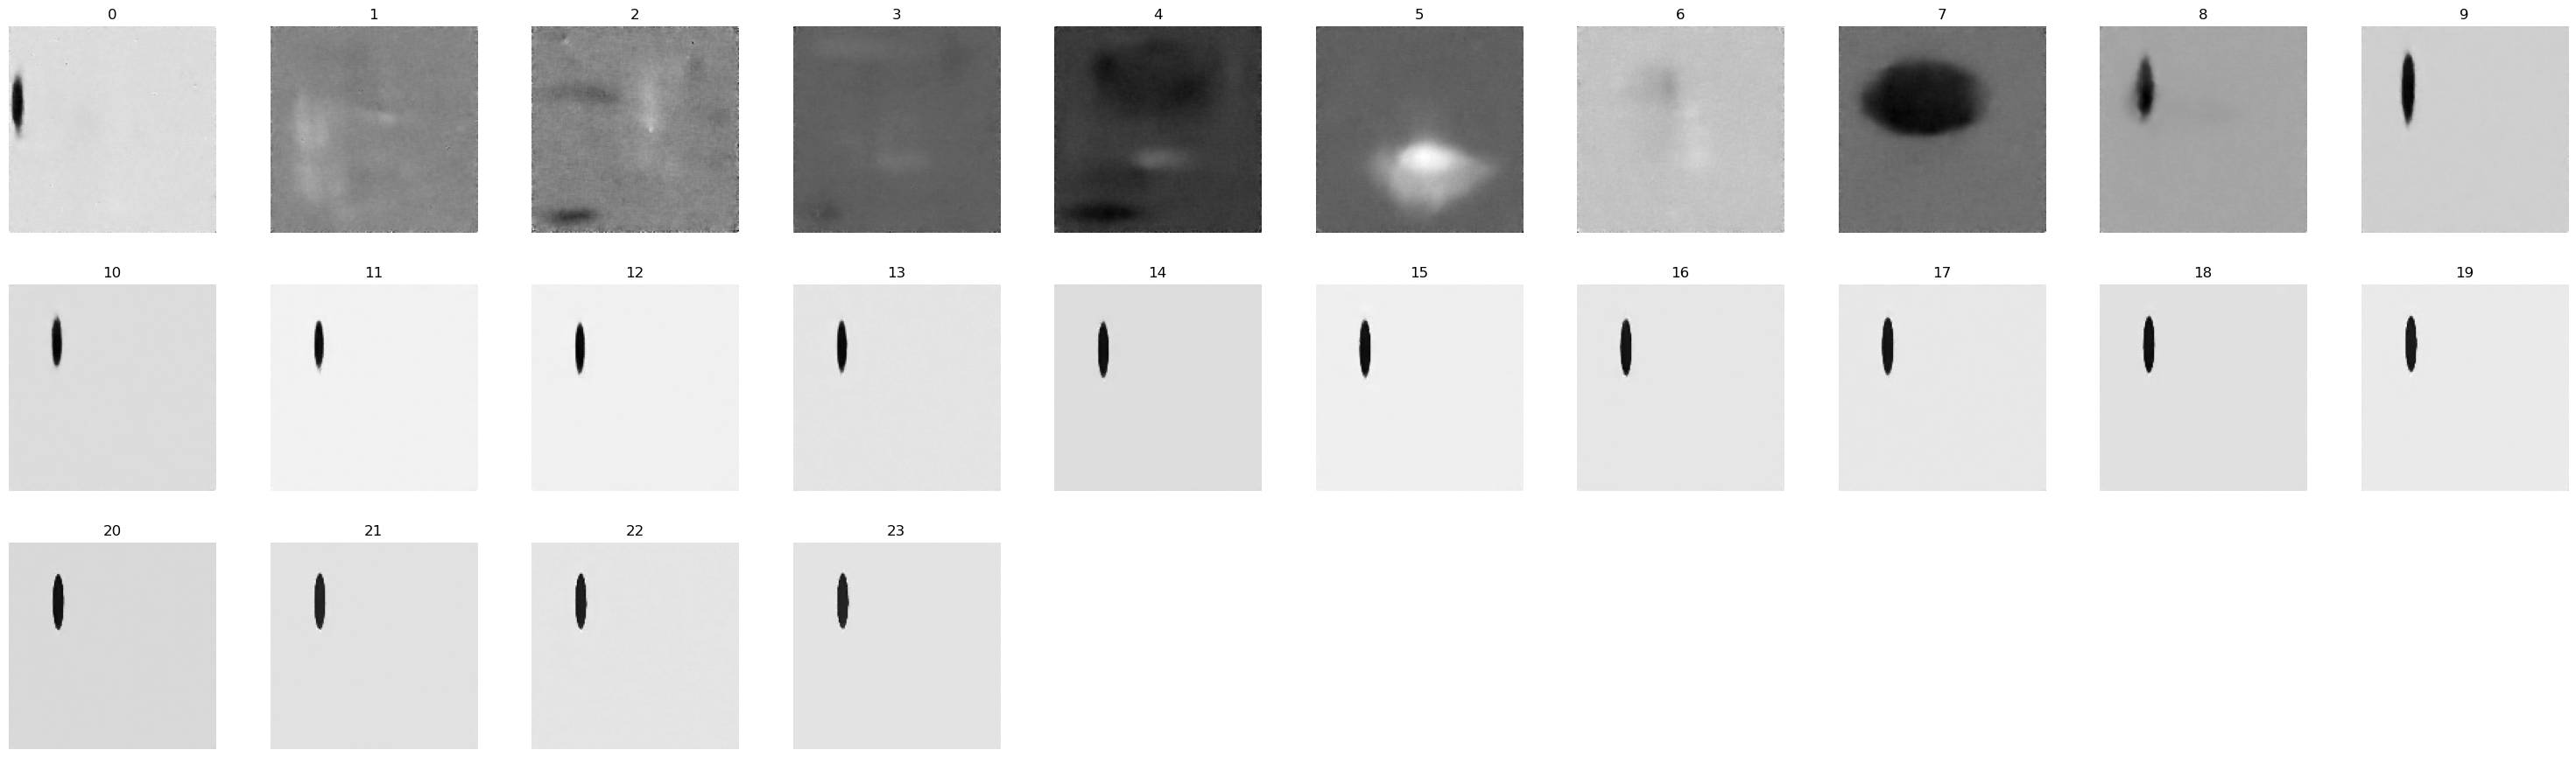

In [22]:
im_n = 2
print('fixed_h=', fixed_h, ' sig_L= ',sig_L, ' h0=', h0, ' beta=',beta, ' seed=', seed)
show_im_set(traj_projections(torch.stack(interm_Ys)[:,im_n], denoisers[group], x_cond=None), n_columns=10)
# show_im_set((torch.stack(interm_Ys)[:,im_n]), n_columns=10)

Most decorrelated images at different noise levels accoring to block:  mid


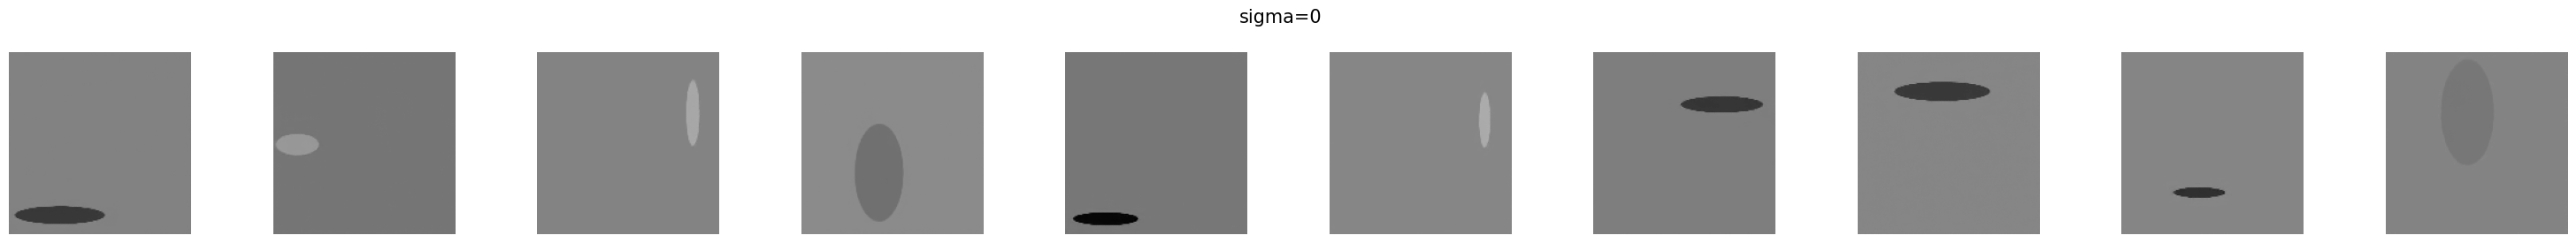

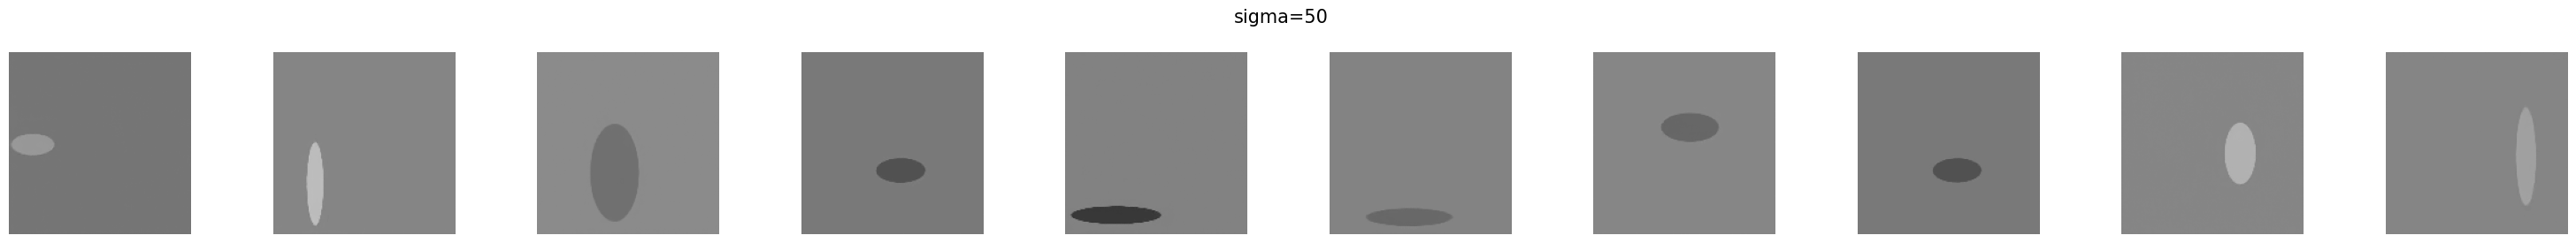

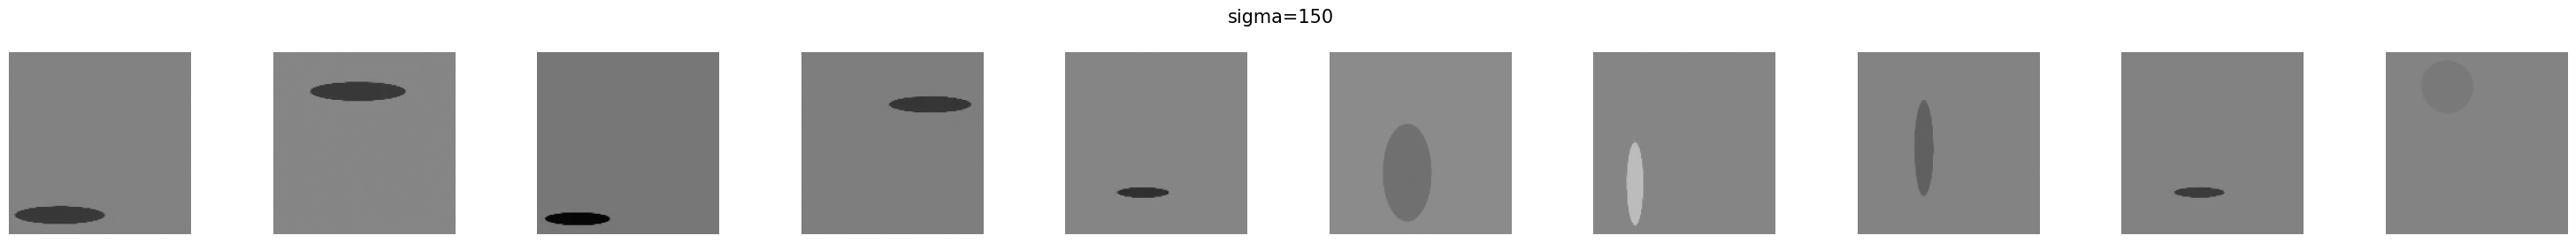

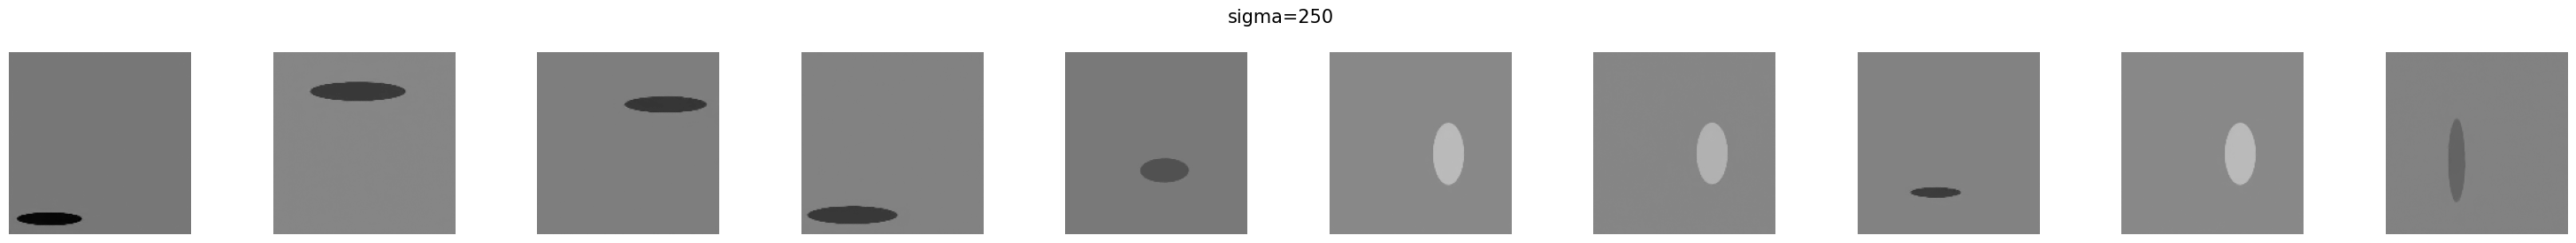

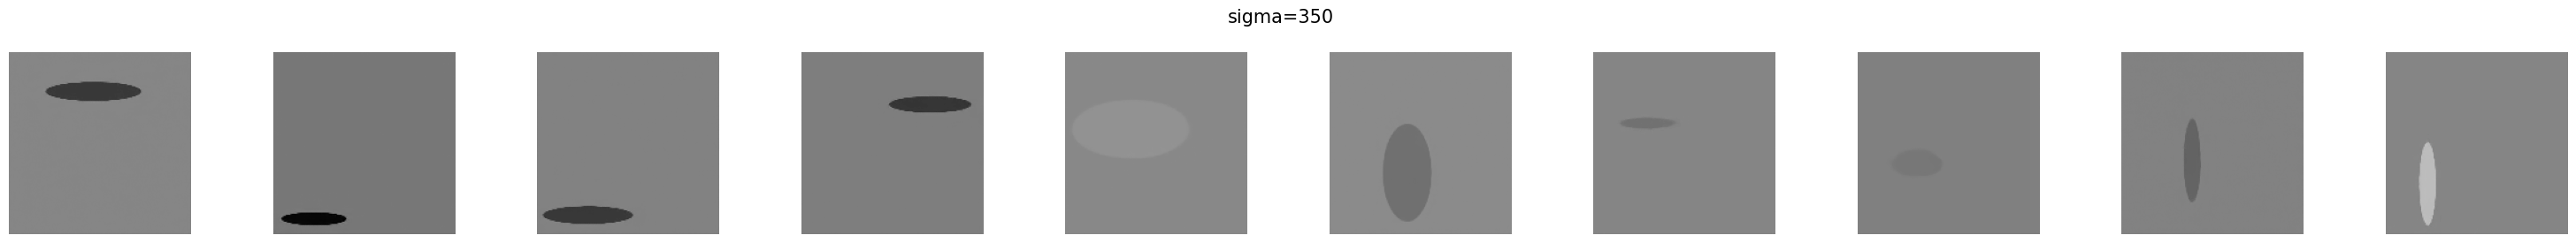

In [25]:
group = 'mixture-gray'
block = 4
im_cond = all_samples['mixture-gray']
print('Most decorrelated images at different noise levels accoring to block: ' , blocks[block])
for sig in [0, 50,150,250,350]:
    phi_1 = get_channel_means(denoisers[group], 
                      add_noise_torch(im_cond.to(device), sig, device=device)[0],
                      device,average_phi=False,with_params=True, return_activations=False)
    
    cov = torch.corrcoef(phi_1[block].squeeze() ).cpu()       
    
    idx = cov.sum(dim = 0).sort()[1]
    # show_im_set(im_cond[idx], n_columns=20, sub_labels= phi_1[block][idx].norm(dim = 1).cpu().squeeze().numpy() ) 
    show_im_set(im_cond[idx][0:10], n_columns=10, sub_labels= ['']* im_cond.shape[0] , label='sigma='+ str(sig), vmin=0, vmax = 1) 


Most decorrelated images across different blocks at noise level:  150


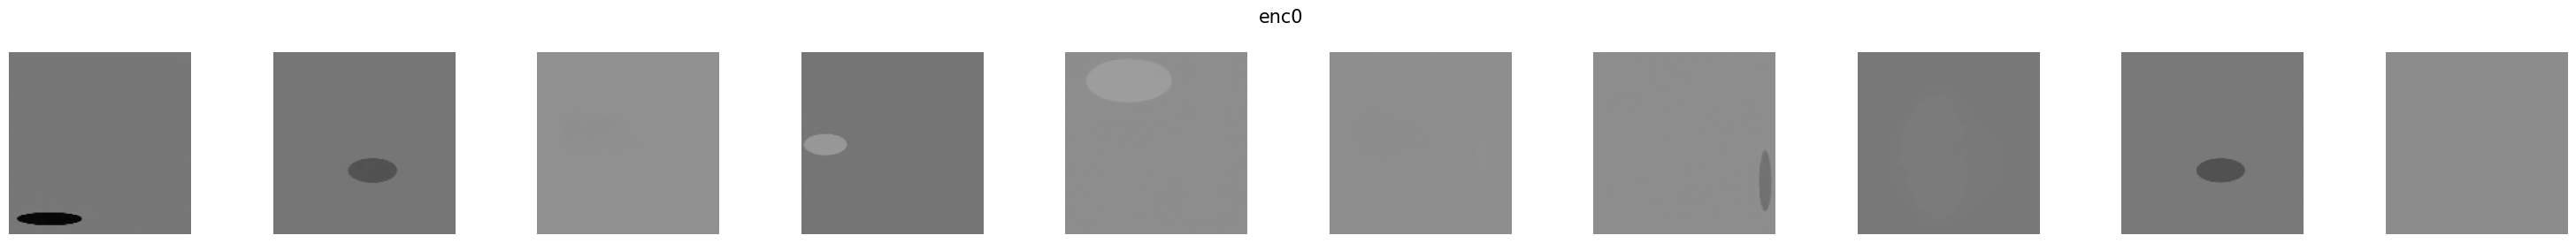

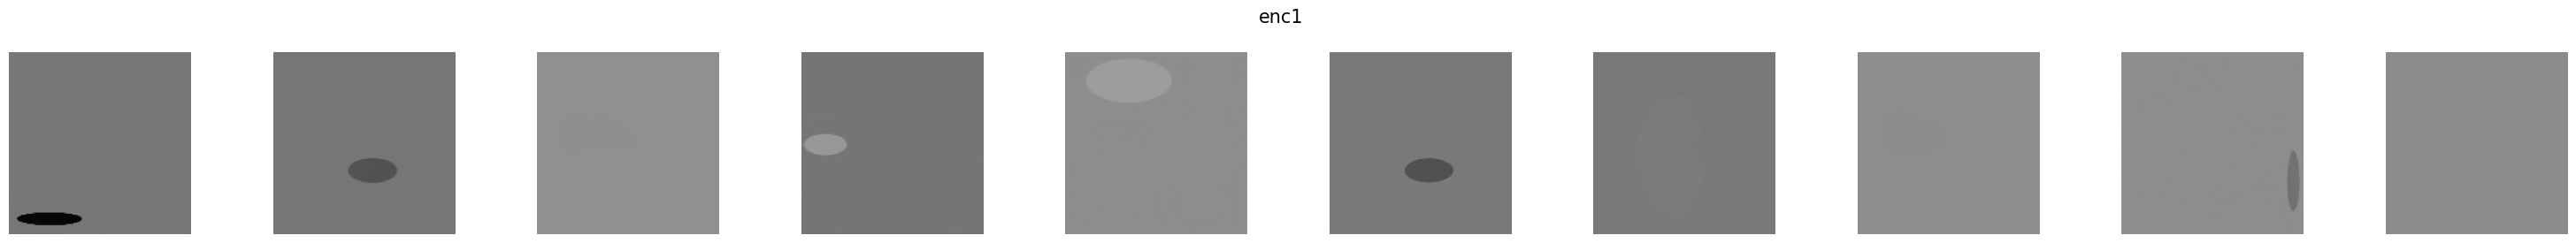

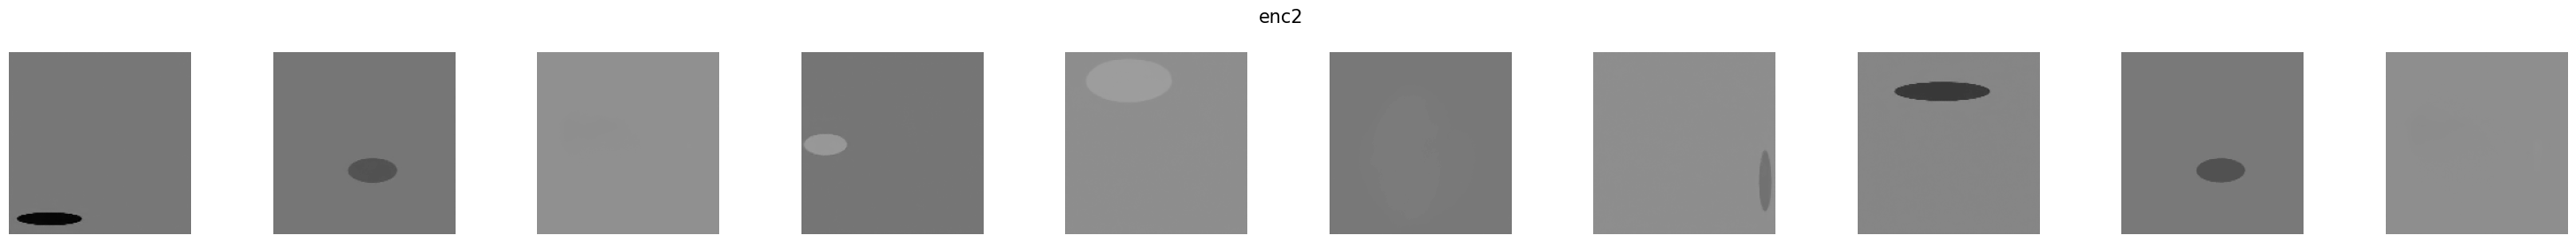

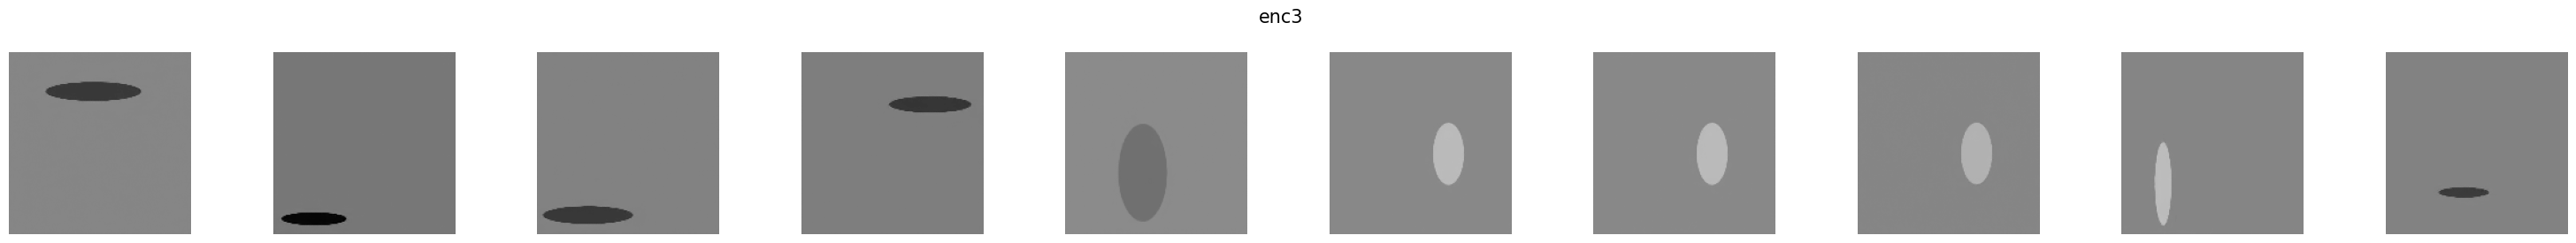

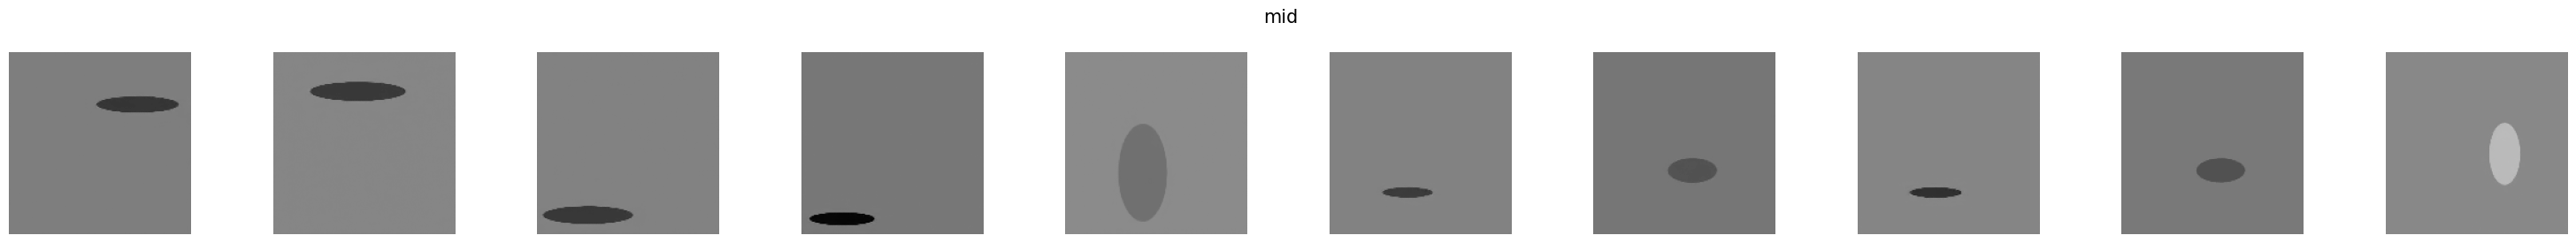

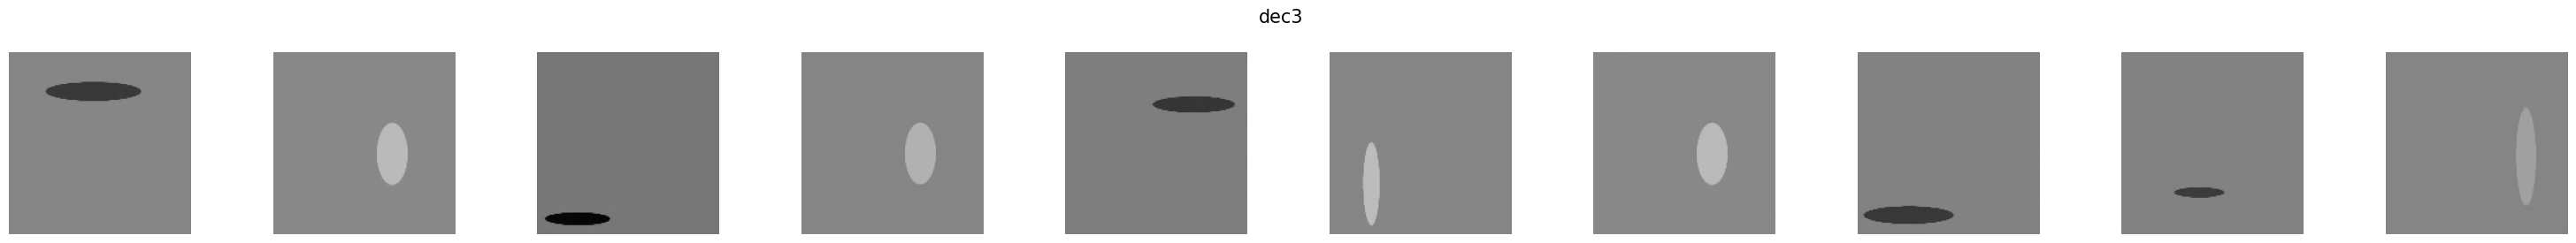

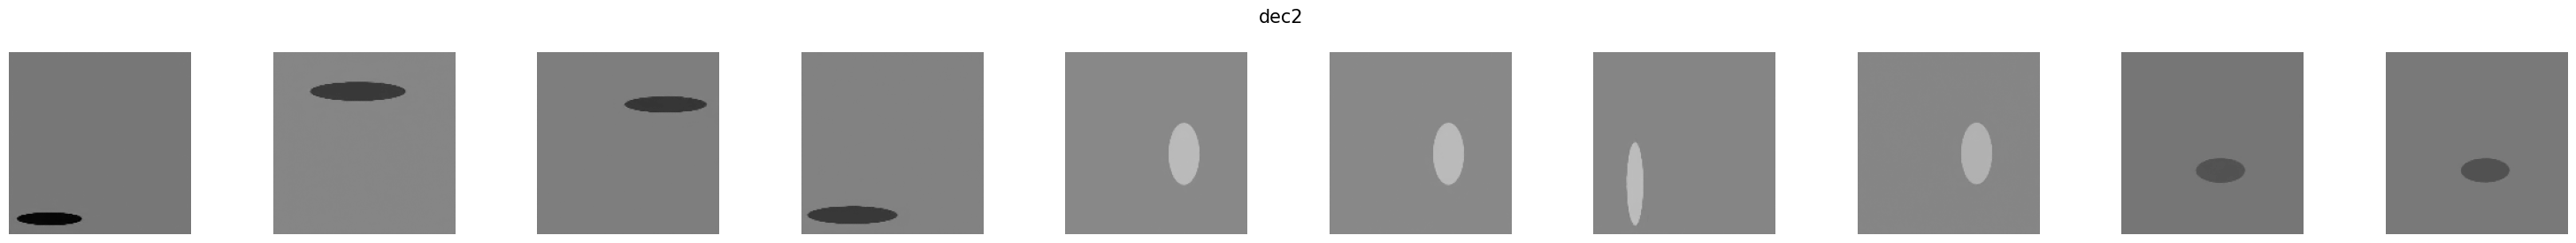

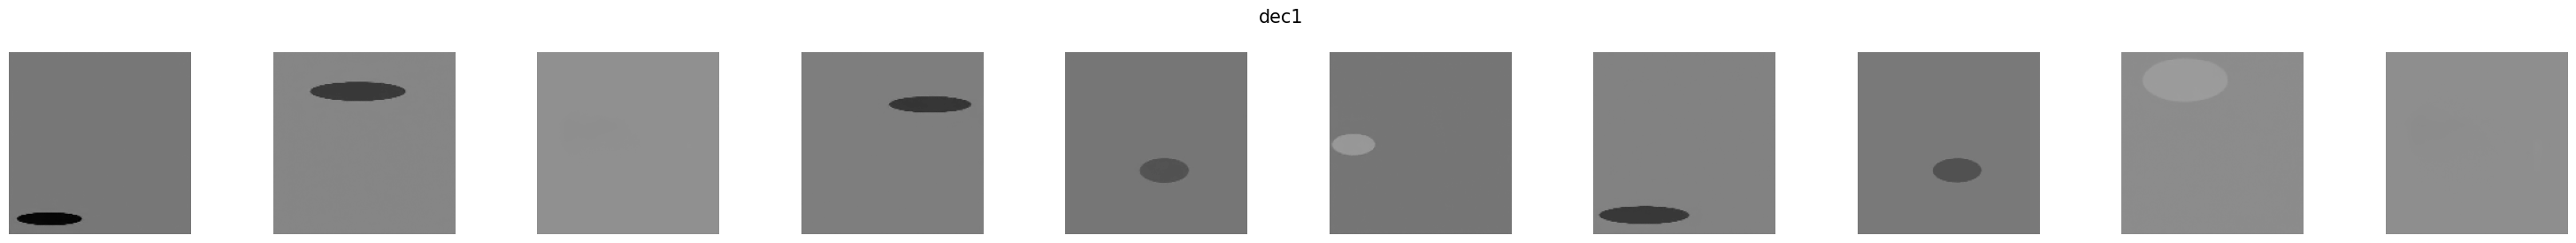

In [24]:
group = 'mixture-gray'
im_cond = all_samples['mixture-gray']
sig = 150
phi_1 = get_channel_means(denoisers[group], 
                      add_noise_torch(im_cond.to(device), sig, device=device)[0],
                      device,average_phi=False,with_params=True, return_activations=False)
print('Most decorrelated images across different blocks at noise level: ' , sig)
for block in range(len(blocks)):
    cov = torch.corrcoef(phi_1[block].squeeze() ).cpu()           
    idx = cov.sum(dim = 0).sort()[1]
    show_im_set(im_cond[idx][0:10], n_columns=10, sub_labels= ['']* im_cond.shape[0] , label=blocks[block],vmin=0, vmax = 1) 

# Synthesis from conditional model

In [27]:

ids_cond = [0,1,2,3,4]


In [28]:
groups

dict_keys(['mixture-gray', 'conditional-gray'])

## Batch synthesis

In [53]:

fixed_h = True
sig_L=.1
h0=.01
beta=.1
###################
n_samples =5
group = 'conditional-gray'

K = 160
shift = 0
seed = None
freq =100
all_samples = {}
all_interm_Ys = {}
all_init = []


im_n = 0
for id in ids_cond: 
    if 'color' in group.split('-'):
        phi = get_channel_means(denoisers[group], train_sets[id][0:100], device, average_phi=True, with_params=False)
        n_channels=3        
    else: 
        phi = get_channel_means(denoisers[group], train_sets[id][0:100].mean(dim=1, keepdim=True), device, average_phi=True, with_params=False)
        n_channels=1
        
    print('------------ class id : ', id )
    start_time_total = time.time()    
    if seed is not None:
        torch.manual_seed(seed )
    if 'color' in group.split('-'):
        init_im = dist_mean.to(device) +torch.randn(n_samples,n_channels,K,K, device = device).to(device)
    else: 
        init_im = dist_mean.mean(dim=0, keepdim=True).to(device)  +torch.randn(n_samples,n_channels,K,K, device = device).to(device)
        
    sample, interm_Ys,_, _ = batch_conditional_synthesis(denoisers[group], 
                                                            x_c = phi, 
                                                            average_phi=False ,
                                                            init_im =init_im,
                                                            sig_0=1, 
                                                            sig_L=sig_L, 
                                                            h0=h0 , 
                                                            beta=beta , 
                                                            freq=freq,
                                                            device=device, 
                                                            fixed_h = fixed_h,
                                                            max_T=10000, 
                                                            seed=seed, 
                                                            output_size=(n_samples,n_channels,K,K))

    print("--- %s seconds ---" % (time.time() - start_time_total))
        
    all_samples[id] = sample.detach()
    all_interm_Ys[id] = interm_Ys


------------ class id :  0
----------------------------- 100
sigma  0.9067527651786804
mean  0.5100495219230652
----------------------------- 200
sigma  0.8227041363716125
mean  0.5047707557678223
----------------------------- 300
sigma  0.7450438141822815
mean  0.5042879581451416
----------------------------- 400
sigma  0.6714536547660828
mean  0.5037201642990112
----------------------------- 500
sigma  0.6087409257888794
mean  0.5063405632972717
----------------------------- 600
sigma  0.5500304102897644
mean  0.5078843235969543
----------------------------- 700
sigma  0.4991266429424286
mean  0.5080966949462891
----------------------------- 800
sigma  0.451541006565094
mean  0.5055668354034424
----------------------------- 900
sigma  0.4081435203552246
mean  0.5088026523590088
----------------------------- 1000
sigma  0.36822983622550964
mean  0.5092939734458923
----------------------------- 1100
sigma  0.3311533033847809
mean  0.509512186050415
----------------------------- 1200
si

fixed_h: True  , sig_L: 0.1  , h0: 0.01  , beta: 0.1 , seed: None
conditional-gray


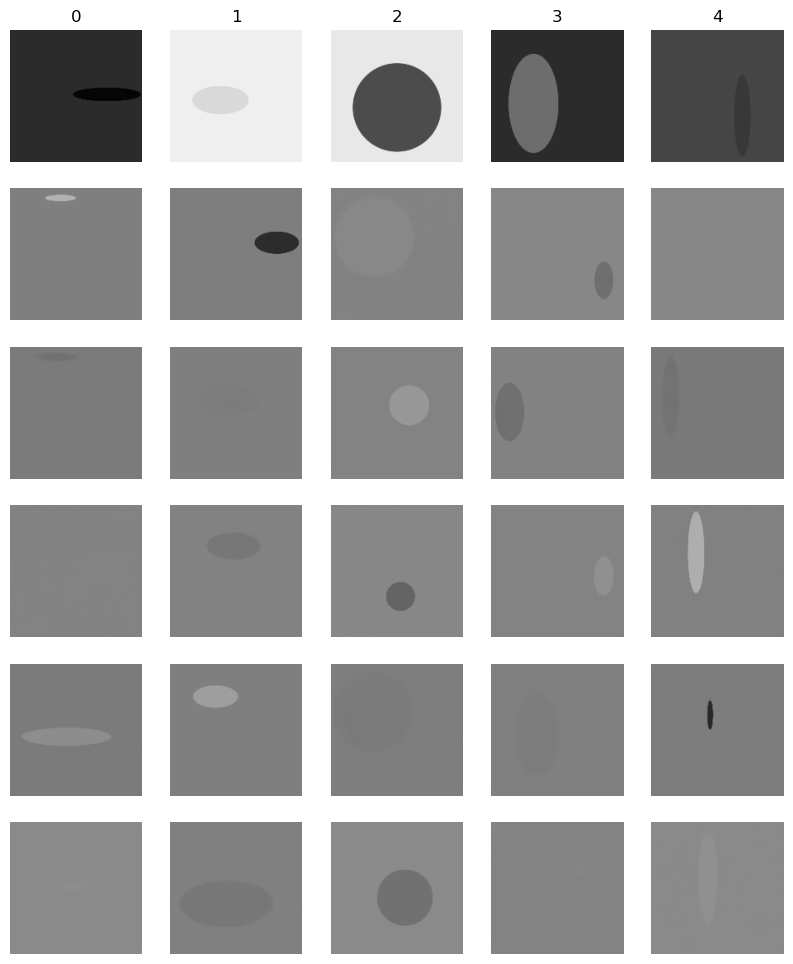

In [54]:
f, axs = plt.subplots( n_samples + 1 , len(ids_cond), figsize=(2*(len(ids_cond) ), 2*(n_samples+1)) )

for i in range(n_samples+1):
    for j in range(len(ids_cond)):
        axs[i,j].axis('off')
   
for i in range(len(ids_cond)): 
    for n in range(n_samples): 
        fig = axs[n+1, i].imshow(np.clip(all_samples[ids_cond[i]][n].permute(1,2,0).squeeze().cpu(), 0,1), 'gray', vmin=0, vmax=1)


for i in range(len(ids_cond)): 
    if 'color' in group.split('-'):
        fig = axs[0, i].imshow(train_sets[i][1].permute(1,2,0).squeeze().cpu(), 'gray')
    else: 
        fig = axs[0, i].imshow(train_sets[i][1].permute(1,2,0).mean(dim=-1, keepdim=True).cpu(), 'gray', vmin=0, vmax=1)
        
    axs[0,i].set_title(ids_cond[i])


print('fixed_h:',fixed_h ,' , sig_L:',sig_L ,' , h0:', h0 , ' , beta:', beta , ', seed:' ,seed)
print(group)


fixed_h: True  , sig_L: 0.1  , h0: 0.01  , beta: 0.1 , seed: 0 , denoiser: conditional-gray


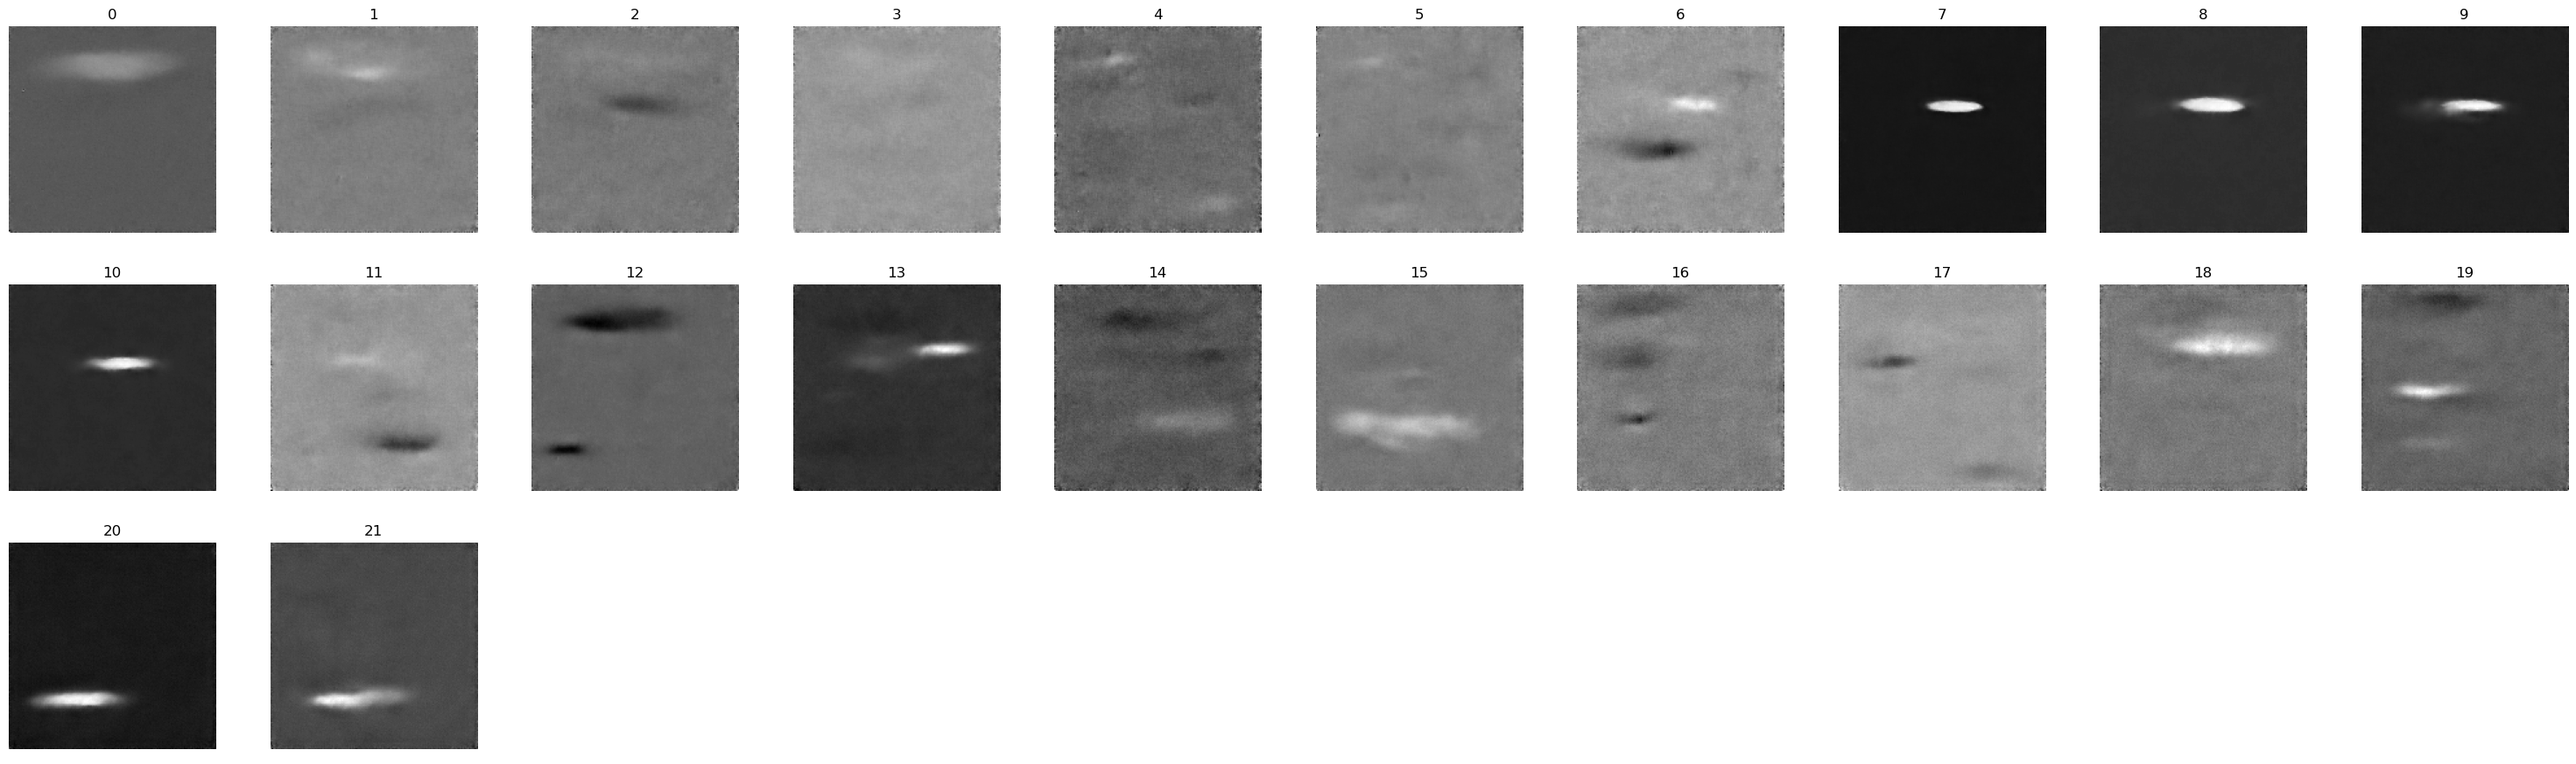

In [44]:
id = 0
im_n = 1

print('fixed_h:',fixed_h ,' , sig_L:',sig_L ,' , h0:', h0 , ' , beta:', beta , ', seed:' ,seed, ', denoiser:', group)
if 'color' in group.split('-'):
    phi = get_channel_means(denoisers[group], train_sets[id], device, average_phi=True, with_params=False)
else: 
    phi = get_channel_means(denoisers[group], train_sets[id].mean(dim=1, keepdim=True), device, average_phi=True, with_params=False)
    n_channels=1
show_im_set(traj_projections(torch.stack(all_interm_Ys[id])[:,im_n], denoisers[group], x_cond=phi), n_columns=10)

# synthesis by conditioning on out of distribution test image

In [45]:
def make_oval_dataset(set_size, aspect_ratios ): 
    # train 
    N = int(set_size/len(aspect_ratios))

    all_data_train = []
    for aspect_ratio in aspect_ratios:
        data = oval_dataset(N, aspect_ratio=aspect_ratio, W=160, H=160).to(device)
        all_data_train.append(data)
    
    #test 
    all_data_test = []
    for aspect_ratio in aspect_ratios:
        data = oval_dataset(N = 100, aspect_ratio=aspect_ratio, W=80, H=80).to(device)
        all_data_test.append(data)
        
    return all_data_train, all_data_test

test_ims, _ = make_oval_dataset(100,[.75, 1/.75]  )

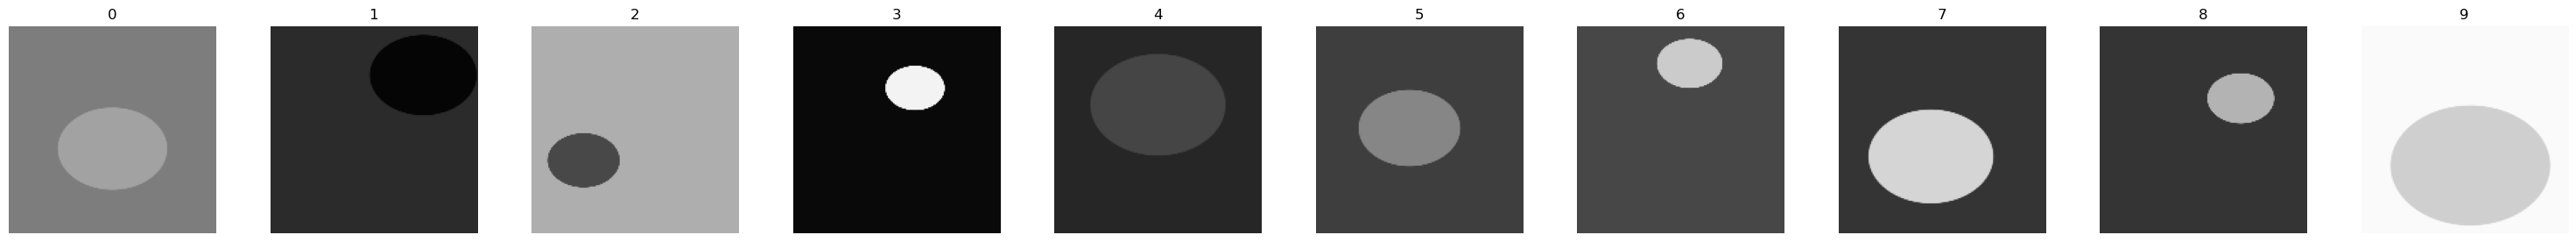

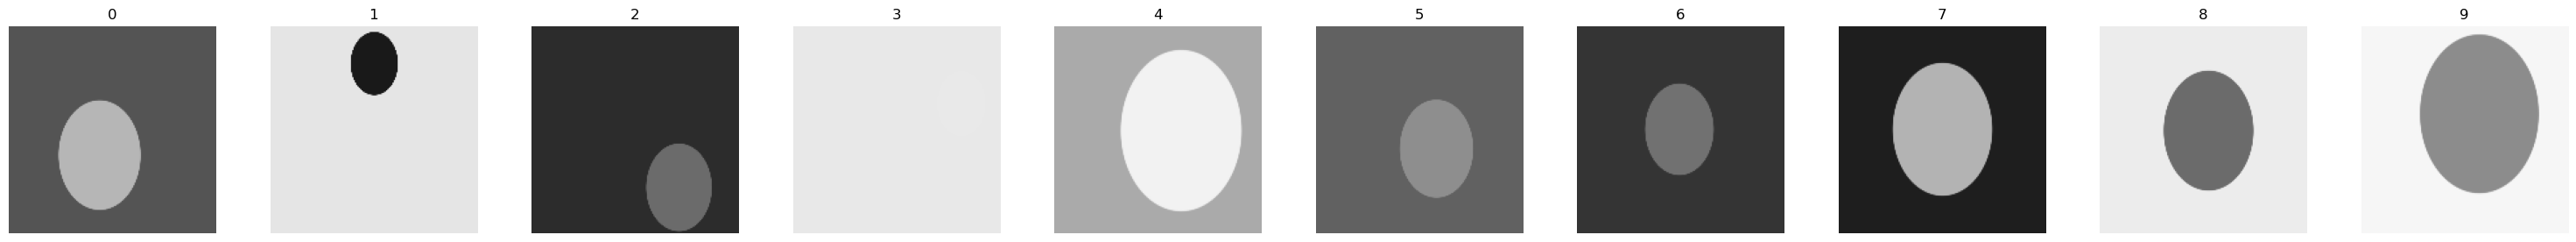

In [46]:
for i in range(len(test_ims)):
    show_im_set(test_ims[i][0:10], vmin=0, vmax = 1 , n_columns=10)


In [47]:

fixed_h = True
sig_L=.1
h0=.01
beta=.1
###################
n_samples =5
group = 'conditional-gray'

K = 160
shift = 0
seed = None
freq =100
all_samples = {}
all_interm_Ys = {}
all_init = []


im_n = 0
for id in range(len(test_ims)): 
    if 'color' in group.split('-'):
        phi = get_channel_means(denoisers[group], test_ims[id][0:100 ], device, average_phi=True, with_params=False)
        n_channels=3        
    else: 
        phi = get_channel_means(denoisers[group], test_ims[id][0:100].mean(dim=1, keepdim=True), device, average_phi=True, with_params=False)
        n_channels=1
        
    print('------------ class id : ', id )
    start_time_total = time.time()    
    if seed is not None:
        torch.manual_seed(seed )
    if 'color' in group.split('-'):
        init_im = dist_mean.to(device) +torch.randn(n_samples,n_channels,K,K, device = device).to(device)
    else: 
        init_im = dist_mean.mean(dim=0, keepdim=True).to(device)  +torch.randn(n_samples,n_channels,K,K, device = device).to(device)
        
    sample, interm_Ys,_, _ = batch_conditional_synthesis(denoisers[group], 
                                                            x_c = phi, 
                                                            average_phi=False ,
                                                            init_im =init_im,
                                                            sig_0=1, 
                                                            sig_L=sig_L, 
                                                            h0=h0 , 
                                                            beta=beta , 
                                                            freq=freq,
                                                            device=device, 
                                                            fixed_h = fixed_h,
                                                            max_T=10000, 
                                                            seed=seed, 
                                                            output_size=(n_samples,n_channels,K,K))

    print("--- %s seconds ---" % (time.time() - start_time_total))
            
    all_samples[id] = sample.detach()
    all_interm_Ys[id] = interm_Ys
    


------------ class id :  0
----------------------------- 100
sigma  0.9077564477920532
mean  0.5136820077896118
----------------------------- 200
sigma  0.8161863684654236
mean  0.511232852935791
----------------------------- 300
sigma  0.7371620535850525
mean  0.5111651420593262
----------------------------- 400
sigma  0.6661065220832825
mean  0.5084875822067261
----------------------------- 500
sigma  0.6054402589797974
mean  0.5105020999908447
----------------------------- 600
sigma  0.5504348278045654
mean  0.5094600915908813
----------------------------- 700
sigma  0.4980786442756653
mean  0.5063349008560181
----------------------------- 800
sigma  0.4507559835910797
mean  0.5079571604728699
----------------------------- 900
sigma  0.40749654173851013
mean  0.5059942007064819
----------------------------- 1000
sigma  0.3686088025569916
mean  0.5057077407836914
----------------------------- 1100
sigma  0.3351151645183563
mean  0.5090426206588745
----------------------------- 1200
s

fixed_h: True  , sig_L: 0.1  , h0: 0.01  , beta: 0.1 , seed: None
conditional-gray


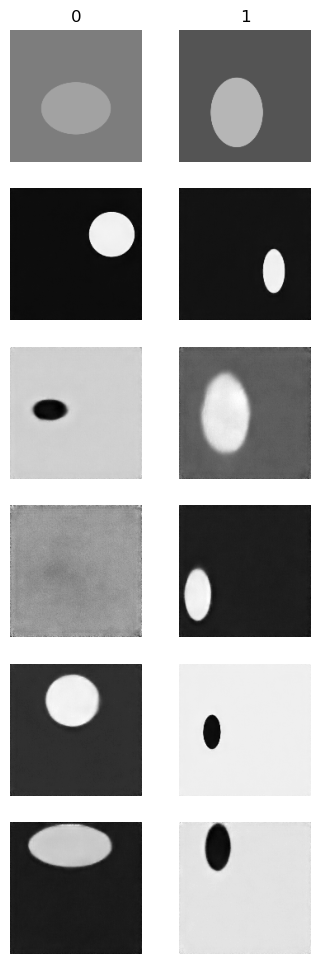

In [50]:
f, axs = plt.subplots( n_samples + 1 , len( all_samples), figsize=(2*(len( all_samples) ), 2*(n_samples+1)) )

for i in range(n_samples+1):
    for j in range(len( all_samples )):
        axs[i,j].axis('off')
   
for i in range(len(test_ims) ): 
    for n in range(n_samples): 
        fig = axs[n+1, i].imshow(np.clip(all_samples[i][n].permute(1,2,0).squeeze().cpu(), 0,1), 'gray')


for i in range(len(test_ims)): 
    if 'color' in group.split('-'):
        fig = axs[0, i].imshow(test_ims[i][0].permute(1,2,0).squeeze().cpu(), 'gray')
    else: 
        fig = axs[0, i].imshow(test_ims[i][0].permute(1,2,0).mean(dim=-1, keepdim=True).cpu(), 'gray', vmin=0, vmax=1)
        
    axs[0,i].set_title(i)


print('fixed_h:',fixed_h ,' , sig_L:',sig_L ,' , h0:', h0 , ' , beta:', beta , ', seed:' ,seed)
print(group)


fixed_h: True  , sig_L: 0.1  , h0: 0.01  , beta: 0.1 , seed: None , denoiser: conditional-gray


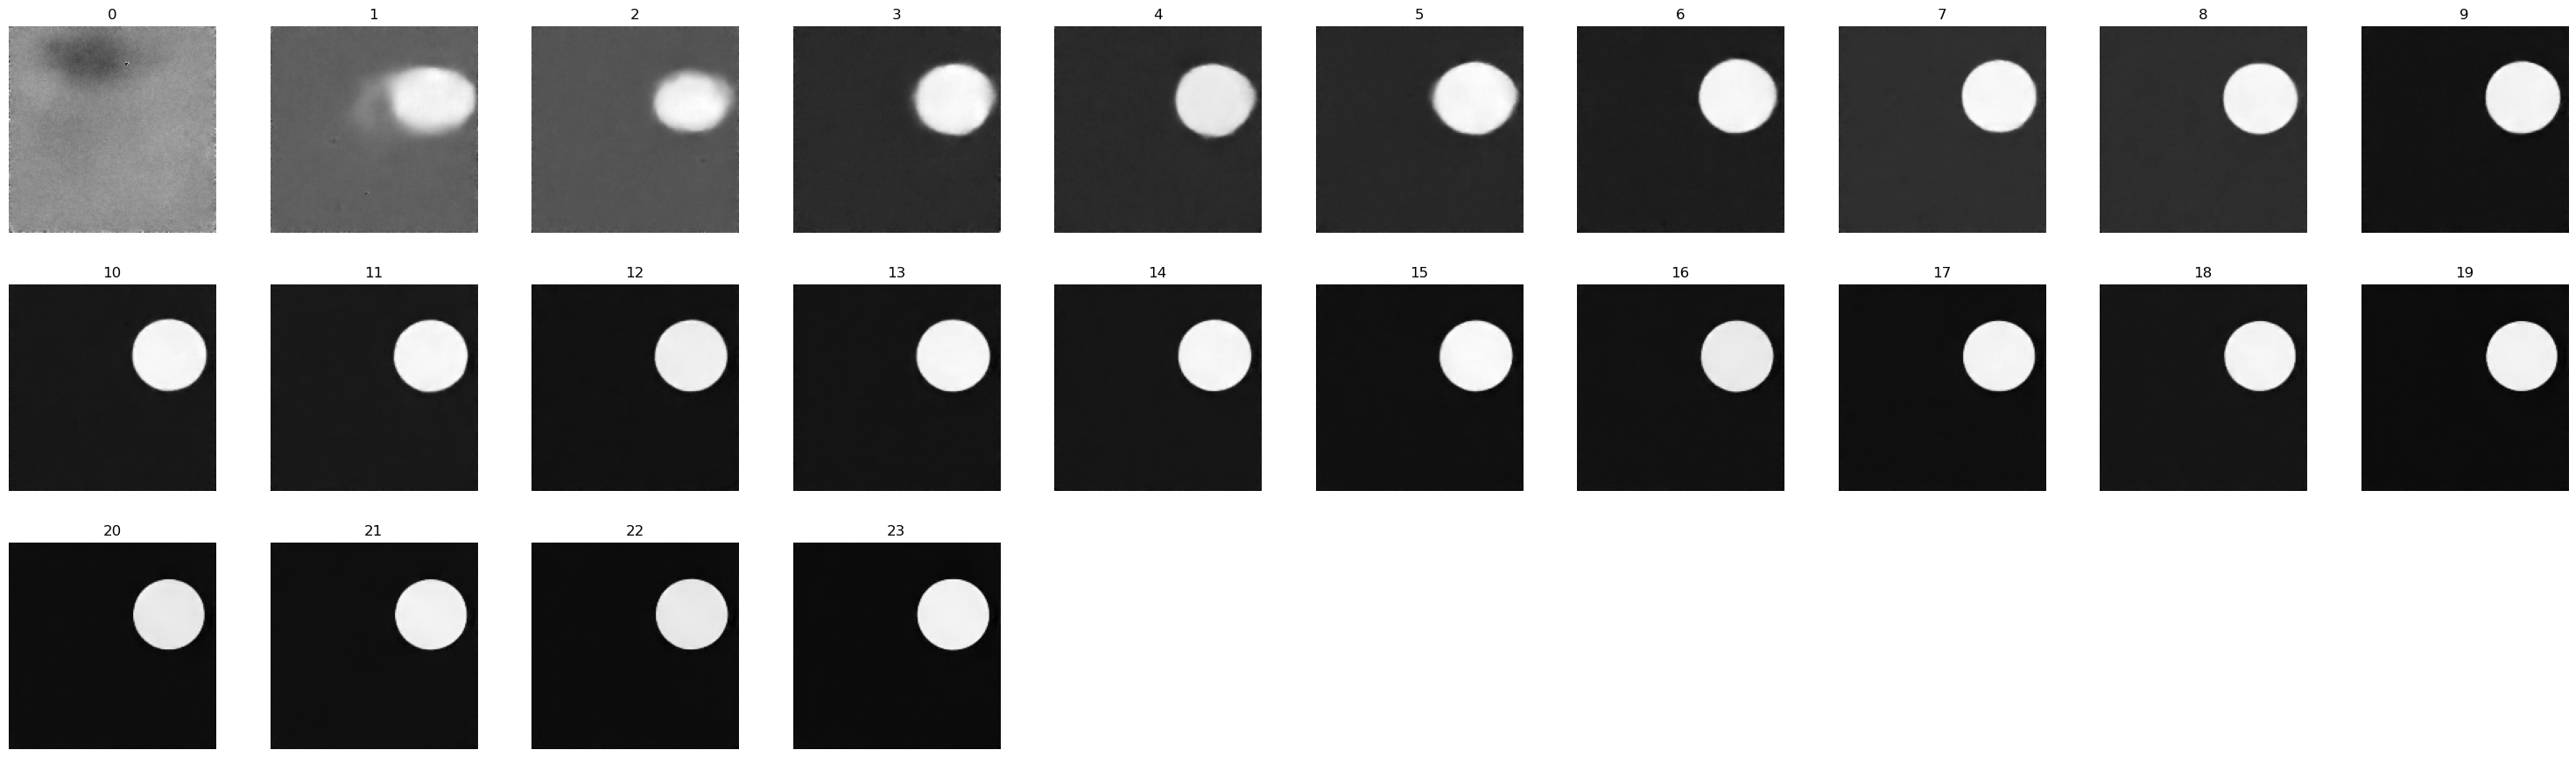

In [49]:
id = 0
im_n = 0
print('fixed_h:',fixed_h ,' , sig_L:',sig_L ,' , h0:', h0 , ' , beta:', beta , ', seed:' ,seed, ', denoiser:', group)
if 'color' in group.split('-'):
    phi = get_channel_means(denoisers[group], test_ims[id][0:100], device, average_phi=True, with_params=False)
else: 
    phi = get_channel_means(denoisers[group], test_ims[id][0:100].mean(dim=1, keepdim=True), device, average_phi=True, with_params=False)
    n_channels=1
    
show_im_set(traj_projections(torch.stack(all_interm_Ys[id])[:,im_n], denoisers[group], x_cond=phi), n_columns=10)

# interpolation 

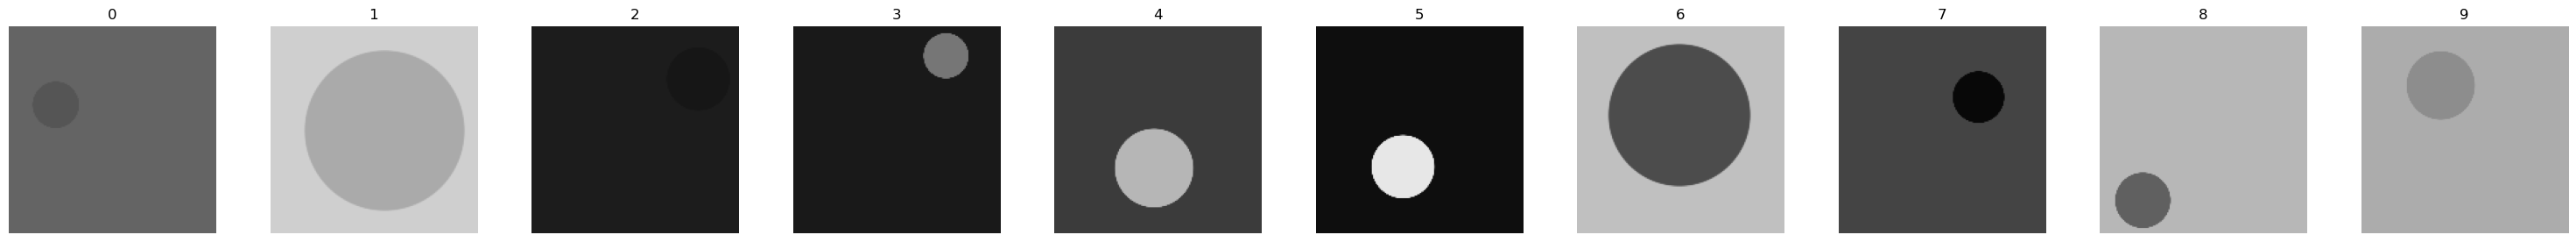

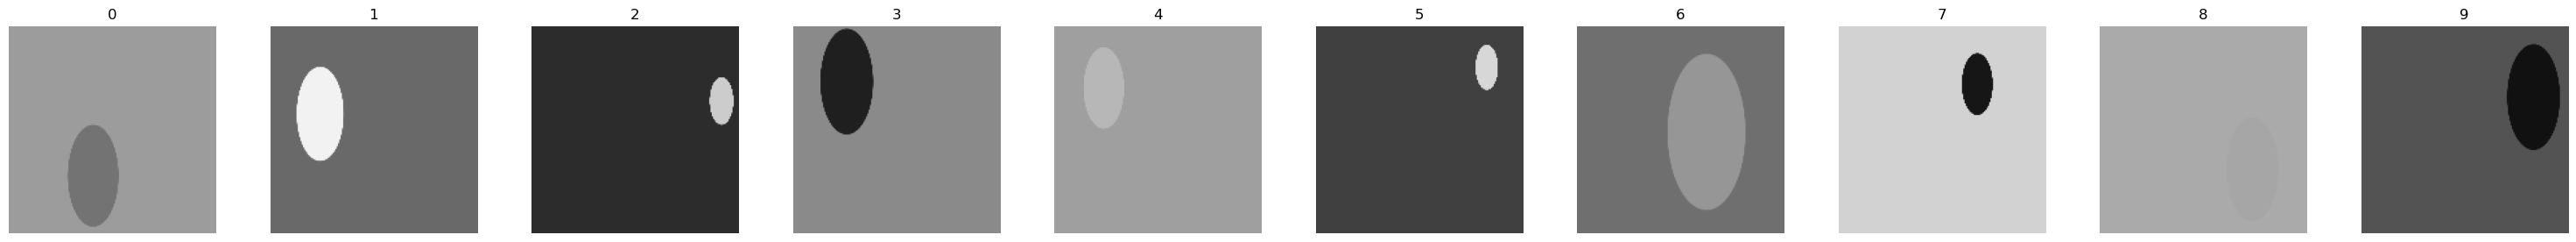

In [100]:

c1 = 2
c2 = 3

show_im_set(test_sets[c1][0:10], n_columns=10, vmin=0, vmax = 1)
show_im_set(test_sets[c2][0:10], n_columns=10, vmin=0, vmax = 1)

In [101]:

group = 'conditional-gray'
e_1 = get_channel_means(denoisers[group], test_sets[c1][0:10], device=device,  average_phi=True, with_params=False) 
e_2 = get_channel_means(denoisers[group], test_sets[c2][0:10], device=device,  average_phi=True, with_params=False)
print('corr: ',torch.dot(torch.hstack(e_1).squeeze() , torch.hstack(e_2).squeeze())/torch.hstack(e_1).norm()/torch.hstack(e_2).norm() )




def interpolate(r, phi1,phi2): 
    temp = []
    for i in range(len(phi1)): 
        temp.append( phi1[i]*r + phi2[i]*(1-r))
    return temp


all_e = []
for r in torch.linspace(0,1,10): 
    all_e.append(interpolate(r, e_1,e_2))





phi_c = True
fixed_h = True
sig_L=.05
h0=.05
beta=.05
# group = 'C'
seed = 2
freq =0
all_samples_interpolate = []
all_init = []

start_time_total = time.time()




im_n = 0
for e in all_e:
    print('------------ im number: ',im_n  )
     
    if seed is not None:
        torch.manual_seed(seed)
    init_im = dist_mean.to(device) +  torch.randn(1,K,K, device = device).to(device)

    sample, interm_Ys,_, _ = conditional_synthesis(denoisers[group], 
                                                            x_c = e, 
                                                            phi_c = True,
                                                            init_im =init_im,
                                                            sig_0=1, 
                                                            sig_L=sig_L, 
                                                            h0=h0 , 
                                                            beta=beta , 
                                                            freq=freq,
                                                            device=device, 
                                                            fixed_h = fixed_h,
                                                            max_T=10000, 
                                                            seed=seed)

    all_samples_interpolate.append(sample.detach())
    # all_interm_Ys[ids_cond[im_n]][n] = interm_Ys
    if im_n == 0: 
        all_init.append(init_im)
    im_n+=1
    
print("--- %s seconds ---" % (time.time() - start_time_total))
all_samples_interpolate = torch.stack(all_samples_interpolate)

corr:  tensor(0.9867, device='cuda:0')
------------ im number:  0
-------- total number of iterations:  1183
-------- final sigma,  0.049835868179798126
-------- final mean  0.46708330512046814
-------- final snr,  0.07194892503321171
------------ im number:  1
-------- total number of iterations:  1185
-------- final sigma,  0.04990510269999504
-------- final mean  0.466586172580719
-------- final snr,  -0.0004317887214710936
------------ im number:  2
-------- total number of iterations:  1185
-------- final sigma,  0.04988370090723038
-------- final mean  0.4668916165828705
-------- final snr,  0.00024228927941294387
------------ im number:  3
-------- total number of iterations:  1183
-------- final sigma,  0.0498647540807724
-------- final mean  0.4674789309501648
-------- final snr,  0.02819371409714222
------------ im number:  4
-------- total number of iterations:  1183
-------- final sigma,  0.04988206550478935
-------- final mean  0.46723610162734985
-------- final snr,  0.05

phi_c:  True fixed_h:  True sig_L 0.05 h0:  0.05 beta:  0.05 seed:  2


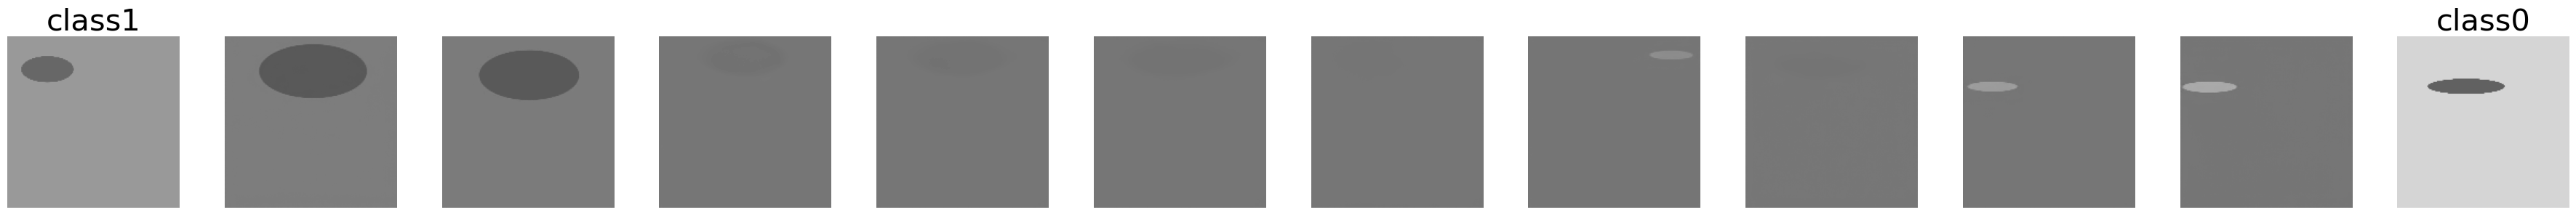

In [91]:
print( 'phi_c: ', phi_c , 'fixed_h: ',fixed_h, 'sig_L' ,sig_L,  'h0: ', h0 ,'beta: ' ,beta, 'seed: ', seed  )
show_im_set( torch.vstack((test_sets[c2][0:1], all_samples_interpolate, test_sets[c1][0:1] )), sub_labels= ['class' + str(c2)] + ['']*10 +['class'+str(c1)],
            n_columns= len(all_samples_interpolate)+2, vmin=0, vmax = 1)


phi_c:  True fixed_h:  True sig_L 0.05 h0:  0.05 beta:  0.05 seed:  2


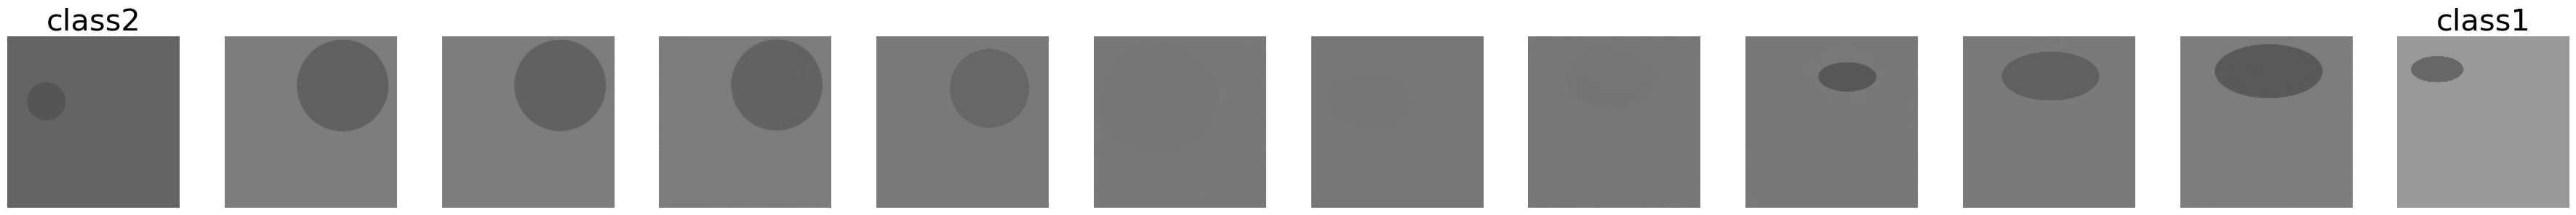

In [81]:
print( 'phi_c: ', phi_c , 'fixed_h: ',fixed_h, 'sig_L' ,sig_L,  'h0: ', h0 ,'beta: ' ,beta, 'seed: ', seed  )
show_im_set( torch.vstack((test_sets[c2][0:1], all_samples_interpolate, test_sets[c1][0:1] )), sub_labels= ['class' + str(c2)] + ['']*10 +['class'+str(c1)],
            n_columns= len(all_samples_interpolate)+2, vmin=0, vmax = 1)


phi_c:  True fixed_h:  True sig_L 0.05 h0:  0.05 beta:  0.05 seed:  2


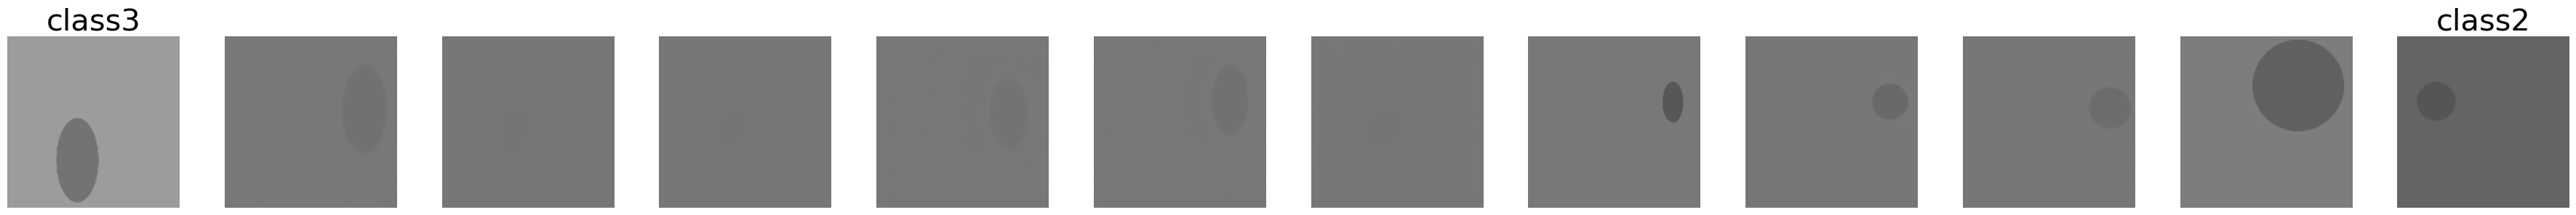

In [102]:
print( 'phi_c: ', phi_c , 'fixed_h: ',fixed_h, 'sig_L' ,sig_L,  'h0: ', h0 ,'beta: ' ,beta, 'seed: ', seed  )
show_im_set( torch.vstack((test_sets[c2][0:1], all_samples_interpolate, test_sets[c1][0:1] )), sub_labels= ['class' + str(c2)] + ['']*10 +['class'+str(c1)],
            n_columns= len(all_samples_interpolate)+2, vmin=0, vmax = 1)


phi_c:  True fixed_h:  True sig_L 0.05 h0:  0.05 beta:  0.05 seed:  2


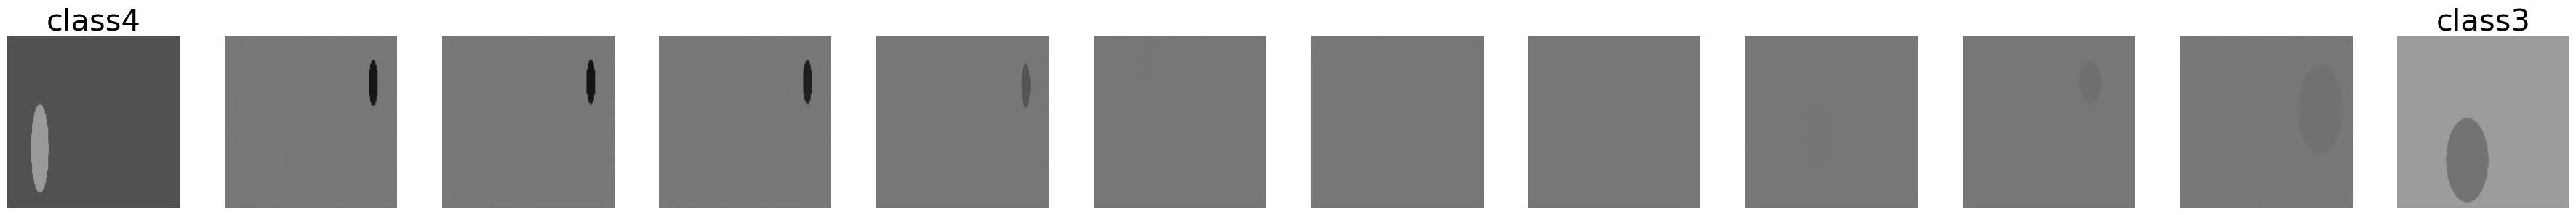

In [88]:
print( 'phi_c: ', phi_c , 'fixed_h: ',fixed_h, 'sig_L' ,sig_L,  'h0: ', h0 ,'beta: ' ,beta, 'seed: ', seed  )
show_im_set( torch.vstack((test_sets[c2][0:1], all_samples_interpolate, test_sets[c1][0:1] )), sub_labels= ['class' + str(c2)] + ['']*10 +['class'+str(c1)],
            n_columns= len(all_samples_interpolate)+2, vmin=0, vmax = 1)

phi_c:  True fixed_h:  True sig_L 0.05 h0:  0.05 beta:  0.05 seed:  2


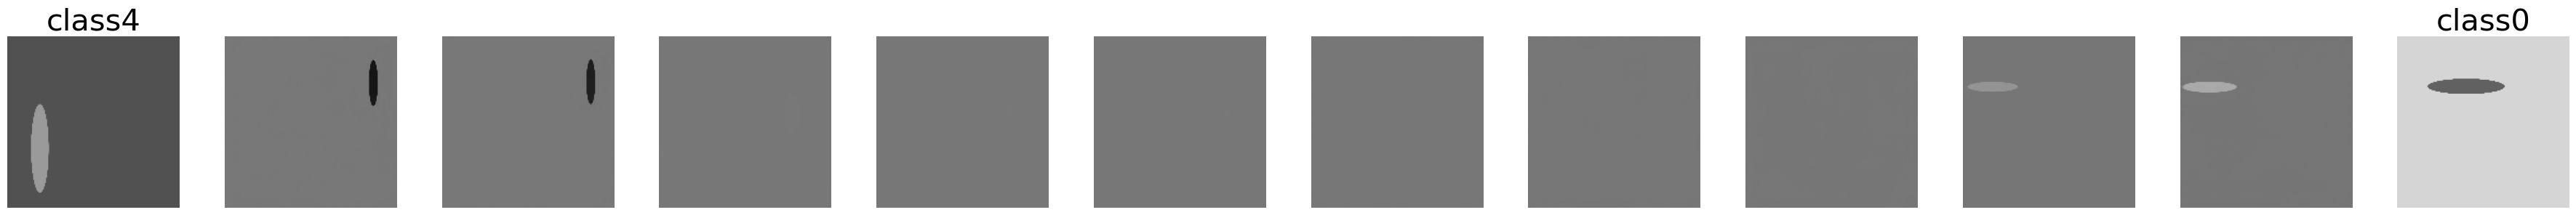

In [96]:
print( 'phi_c: ', phi_c , 'fixed_h: ',fixed_h, 'sig_L' ,sig_L,  'h0: ', h0 ,'beta: ' ,beta, 'seed: ', seed  )
show_im_set( torch.vstack((test_sets[c2][0:1], all_samples_interpolate, test_sets[c1][0:1] )), sub_labels= ['class' + str(c2)] + ['']*10 +['class'+str(c1)],
            n_columns= len(all_samples_interpolate)+2, vmin=0, vmax = 1)

phi_c:  True fixed_h:  True sig_L 0.05 h0:  0.05 beta:  0.05 seed:  2


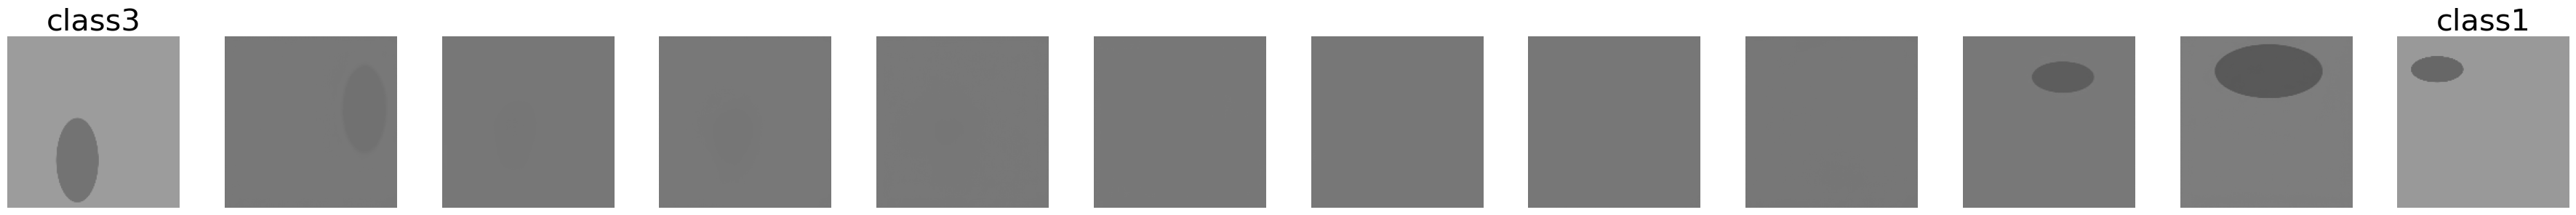

In [99]:
print( 'phi_c: ', phi_c , 'fixed_h: ',fixed_h, 'sig_L' ,sig_L,  'h0: ', h0 ,'beta: ' ,beta, 'seed: ', seed  )
show_im_set( torch.vstack((test_sets[c2][0:1], all_samples_interpolate, test_sets[c1][0:1] )), sub_labels= ['class' + str(c2)] + ['']*10 +['class'+str(c1)],
            n_columns= len(all_samples_interpolate)+2, vmin=0, vmax = 1)

# Use the mixture model as a conditional model 

In [17]:
def initialize_network(network_name, args):
    '''
    Function to dynamically initialize a neural network by class name
    '''
    if network_name in globals() and issubclass(globals()[network_name], nn.Module):
        return globals()[network_name](args)
    else:
        raise ValueError(f"Network {network_name} not found or not a subclass of nn.Module")

        
def load_learned_model(folder_path, print_args=False): 
    '''
    Loads dictionary of all args used to define the model for training and then loads the saved trained model with the specified parameters.
    This can only be used if the network parameters were saved in advanced.
    '''
    with (open(folder_path +'exp_arguments.pkl' , "rb")) as openfile:
        arguments = pickle.load(openfile)    
    
    if print_args: 
        print('*************** saved arguments:*************')
        for key,v in arguments.items(): 
            print(key, v)
    parser = argparse.ArgumentParser(description='set CNN args')

    for k,v in arguments.items(): 
        parser.add_argument('--' + k, default=v)
    args = parser.parse_args('')
    
    args.arch_name = 'UNet_conditional_mean_matching'
    model = initialize_network(args.arch_name, args)
    if torch.cuda.is_available():
        model = model.cuda()
        
    model = read_trained_params(model, folder_path + '/model.pt')
    print('******************************************************')
    print('number of parameters is ' , sum(p.numel() for p in model.parameters() if p.requires_grad))

    model.eval()
    print('train mode:', model.training )
    return model      


##################################################################################################
def read_trained_params(model, path): 
    '''reads parametres of saved models into an initialized network'''
    if torch.cuda.is_available():
        learned_params =torch.load(path, weights_only=True)
    else:
        learned_params =torch.load(path, map_location='cpu' , weights_only=True)
        
    ## unwrap if in Dataparallel 
    new_state_dict = {}
    for key,value in learned_params.items(): 
        if key.split('.')[0] == 'module': 
            new_key = '.'.join(key.split('.')[1::])
            new_state_dict[new_key] = value

        else: 
            new_state_dict[key] = value
        

    model.load_state_dict(new_state_dict, strict=False)        
    model.eval();

    return model




In [18]:

group = 'mixture-modified-gray'

path = root_path + 'UNet_flex/ovals/0to255_RF_172x172_set_size_100000_gray_5_classes_160x160/'

print('loading group ' , group )
denoisers[group] = load_learned_model(path, print_args=True)


loading group  mixture-modified-gray
*************** saved arguments:*************
arch_name UNet_flex
lr 0.001
batch_size 512
num_epochs 1000
lr_freq 100
loss_weight False
noise_level_range [0, 255]
quadratic_noise True
rescale False
swap False
set_size 100000
imagenet_subset_ids None
self_cond False
data_name ovals
data_root_path /mnt/home/zkadkhodaie/ceph/datasets/
dir_name /mnt/home/zkadkhodaie/ceph/21_hierarchical_conditional_prior/denoisers/UNet_flex/ovals/0to255_RF_172x172_set_size_100000_gray_5_classes_160x160
optional_dir_label gray_5_classes
device cuda
debug False
kernel_size 3
padding 1
skip True
num_channels 1
bias True
RF 172
coarse True
num_kernels [16, 32, 64, 128, 256]
num_blocks 4
num_enc_conv [2, 2, 2, 2]
num_mid_conv 3
num_dec_conv [2, 2, 2, 2]
NormType LayerNorm
match_only_mid True
nonlinear_enc True
******************************************************
number of parameters is  2531121
train mode: False


In [19]:
def batch_conditional_synthesis(model, 
                          x_c , 
                          average_phi=False,
                          init_im=None, 
                          sig_0=1, 
                          sig_L=.01, 
                          h0=.01, 
                          beta=.01, 
                          freq=0,
                          device=None, 
                          fixed_h = False,
                          max_T=None, 
                          seed=None, 
                          output_size=None):
    
    '''
    @x_c: conditioning image of size (B,C,H,W). It could also be a list of tensors of pre-computed phi_c
    @average_phi: if True, the network uses phi_c computed from a batch of images (or pre-saved from batch of images)
    @init_im: if not None, synthesis starts from init_im rather than white noise. Size=(B,C, H,W)
    @sig_0: initial sigma (largest)
    @sig_L: final sigma (smallest)
    @h0: 1st step size
    @beta:controls added noise in each iteration (0,1]. if 1, no noise is added. As it decreases more noise added.
    @output_size: if None, same as x_c. Else, size of the generated images: (B', C, H', W'). Should match init_im size. 
    '''

    ## Set B, C, H, W from inputs
    if output_size is not None: 
        B, C, H, W = output_size
    else:  
        if init_im is not None:
            B, C, H,W = init_im.size()
        else: 
            if type(x_c) != list:
                B, C, H,W = x_c.size()
            else: 
                raise TypeError('Output dimensions is not provided')
    
    ## ambient dimensionality                 
    N = C*H*W 
    
    ## set the seed
    if seed is not None: 
        torch.manual_seed(seed)

    ## initialize the init image 
    if init_im is not None:
        y = init_im 
    else: 
        e = torch.zeros((B,C ,H,W), requires_grad= False , device=device)
        y = torch.normal(e, sig_0).to(device)
    y.requires_grad = False

    ## lists to collect stuff 
    intermed_Ys=[]
    sigmas = []
    means = []
    
    if freq > 0:
        intermed_Ys.append(y)

    t=1
    sigma = torch.ones(B)*sig_0
    start_time_total = time.time()
    x_c = torch.vstack([x_c]*B )
    update_mask = torch.ones((B,1,1,1), device=device)
    while sigma.max() > sig_L :  
        
        h = h0
        
        if fixed_h is False:
            h = h0*t/(1+ (h0*(t-1)) )


        x_c_noisy = x_c+ torch.randn(size = x_c.size() , device = device) * sigma.reshape((B, 1,1,1)).to(device)
        # x_c_noisy = x_c+ torch.randn(size = x_c.size() , device = device) * torch.ones((B, 1,1,1)).to(device)*.2
        
        with torch.no_grad():
            f_y = model(y, x_c_noisy, average_phi)             
 
                
        
        sigma = torch.norm(f_y, dim=(2,3),keepdim=True).norm(dim=1,keepdim=True)/np.sqrt(N)
        
        sigmas.append(sigma)
        
        gamma = sigma*np.sqrt(((1 - (beta*h))**2 - (1-h)**2 ))
        noise = torch.randn(B,C, H, W, device=device) 
        update_mask[sigma<sig_L] = 0 
        if freq > 0 and t%freq== 0:
            print('-----------------------------', t)
            print('sigma ' , sigma.mean().item() )
            print('mean ', y.mean().item() )
            intermed_Ys.append(y* update_mask- f_y)
            
        y = y -  (h*f_y + gamma*noise ) * update_mask
        means.append(y.mean(dim=(2,3)) )
        # snr = 20*torch.log10((y.std()/sigma)).item()        
        
        
        t +=1
        if max_T is not None and t>max_T:
            print('max T surpassed')
            break
        if sigma.max() > 2:
            print('not converging')
            break
    print('-------- total number of iterations: ', t)
    print("-------- final sigma, " , sigma.mean().item() )
    print('-------- final mean ', y.mean(dim=(2,3)).mean().item() )
    print("-------- final snr, " , 20*torch.log10((y.std()/sigma)).mean().item() )



    denoised_y = y - model(y,x_c_noisy, average_phi)    
        


    return denoised_y, intermed_Ys, sigmas, means

In [14]:

def interpolated_conditioner(var,n=21): 
    width = 60
    height = 60
    fg_intensity = .7
    bg_intensity = .2
    c1 = 0 
    c2 = 0
    ovalsH = []


    if var == 'width': 
        height = 100        
        ws = torch.linspace(height ,height * .5,n)  
        for i in range(n): 
            width =  ws[i]
            oval_tensor = generate_oval(width=width, height=height, size= (160, 160), blur=160, fg_intensity=fg_intensity, bg_intensity=bg_intensity, center=(c1,c2) )
            ovalsH.append(oval_tensor)

    if var == 'height': 
        width = 100
        hs = torch.linspace(width ,width * .2,n)    
        for i in range(n): 
            height = hs[i]
            oval_tensor = generate_oval(width=width, height=height, size= (160, 160), blur=160, fg_intensity=fg_intensity, bg_intensity=bg_intensity, center=(c1,c2) )
            ovalsH.append(oval_tensor)
            
    if var == 'aspect_ratio': 
        ws = torch.linspace(10,100,n)
        hs = ws.flip(dims = (0,))        
        
        for i in range(n): 
            width =  ws[i]
            height = hs[i]
            oval_tensor = generate_oval(width=width, height=height, size= (160, 160), blur=160, fg_intensity=fg_intensity, bg_intensity=bg_intensity, center=(c1,c2) )
            ovalsH.append(oval_tensor)


    elif var == 'bg_intensity':     
        bgs = torch.linspace(0,fg_intensity-.05,n)  
        for i in range(n): 
            bg_intensity = bgs[i]
            oval_tensor = generate_oval(width=width, height=height, size= (160, 160), blur=160, fg_intensity=fg_intensity, bg_intensity=bg_intensity, center=(c1,c2) )
            ovalsH.append(oval_tensor)

    elif var == 'fg_intensity':     
        fgs = torch.linspace(bg_intensity+.05,1,n)  
        for i in range(n): 
            fg_intensity = fgs[i]
            oval_tensor = generate_oval(width=width, height=height, size= (160, 160), blur=160, fg_intensity=fg_intensity, bg_intensity=bg_intensity, center=(c1,c2) )
            ovalsH.append(oval_tensor)
    
    elif var == 'fg_bg_intensities': 
        fgs = torch.linspace(0,1,n)  
        bgs = fgs.flip(dims = (0,))         
        for i in range(n): 
            fg_intensity = fgs[i]
            bg_intensity = bgs[i]            
            oval_tensor = generate_oval(width=width, height=height, size= (160, 160), blur=160, fg_intensity=fg_intensity, bg_intensity=bg_intensity, center=(c1,c2) )
            ovalsH.append(oval_tensor)
            
    elif var == 'h_translation':        
        c1s = torch.linspace(-  (160 - 60)/160 , (160 - 60)/160 ,n) 
        for i in range(n): 
            c1 = c1s[i]
            oval_tensor = generate_oval(width=width, height=height, size= (160, 160), blur=160, fg_intensity=fg_intensity, bg_intensity=bg_intensity, center=(c1,c2) )
            ovalsH.append(oval_tensor)

    elif var == 'v_translation': 
        c2s = torch.linspace(-  (160 - 60)/160 , (160 - 60)/160 ,n) 
        for i in range(n): 
            c2 = c2s[i]
            oval_tensor = generate_oval(width=width, height=height, size= (160, 160), blur=160, fg_intensity=fg_intensity, bg_intensity=bg_intensity, center=(c1,c2) )
            ovalsH.append(oval_tensor)

    elif var == 'oval_size': 
        ss = torch.linspace(.1, 2, n)
        for i in range(n): 
            s = ss[i]
            oval_tensor = generate_oval(width=width*s, height=height*s, size= (160, 160), blur=160, fg_intensity=fg_intensity, bg_intensity=bg_intensity, center=(c1,c2) )
            ovalsH.append(oval_tensor)
            
    return torch.stack(ovalsH).unsqueeze(1)
    #### plot

def plot_phi_corr(im_cond, sig=0): 
    for group in ['mixture-gray','conditional-gray' ]:
        if 'gray' in group.split('-'): 
            im_cond = im_cond.mean(dim = 1, keepdim = True)
        if 'mixture' in group: 
            phi_xc = get_channel_means(denoisers[group], add_noise_torch(im_cond, sig)[0],average_phi=False,with_params=True , return_activations=False)
        else: 
            phi_xc = get_channel_means(denoisers[group], im_cond,average_phi=False,with_params=True , return_activations=False)

        
        f, axs = plt.subplots(1, len(blocks), figsize = (18,3))
        plt.suptitle(group)
        for block in range(len(blocks)): 
            axs[block].imshow(torch.abs(torch.corrcoef(phi_xc[block].squeeze() )).cpu() , 'gray',vmin=0, vmax = 1)
            axs[block].tick_params(bottom=False,top = False, right = False, left=False)
            axs[block].set_xticks([])  
            axs[block].set_yticks([])      
            axs[block].set_title(blocks[block])
        plt.tight_layout()
        

    show_im_set(im_cond, n_columns=len(im_cond), vmin=0, vmax = 1)


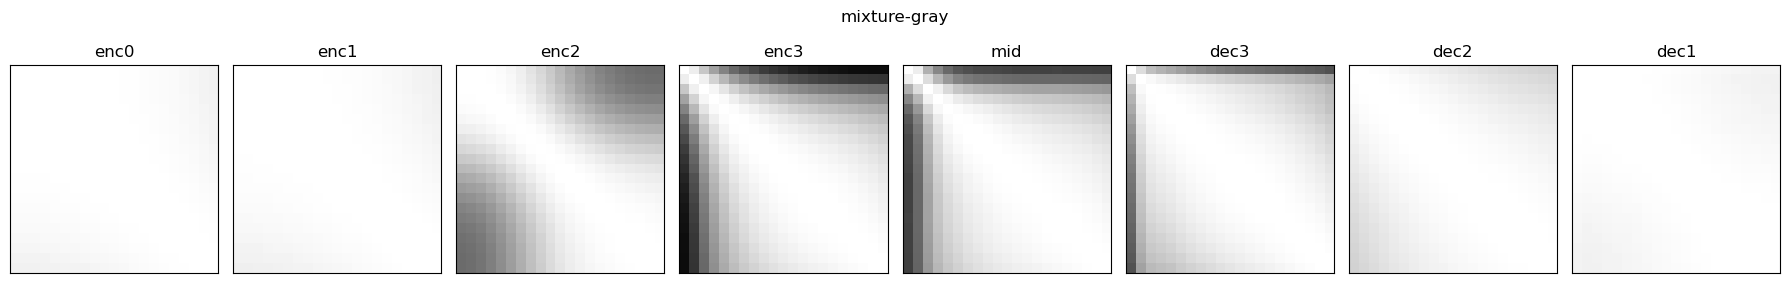

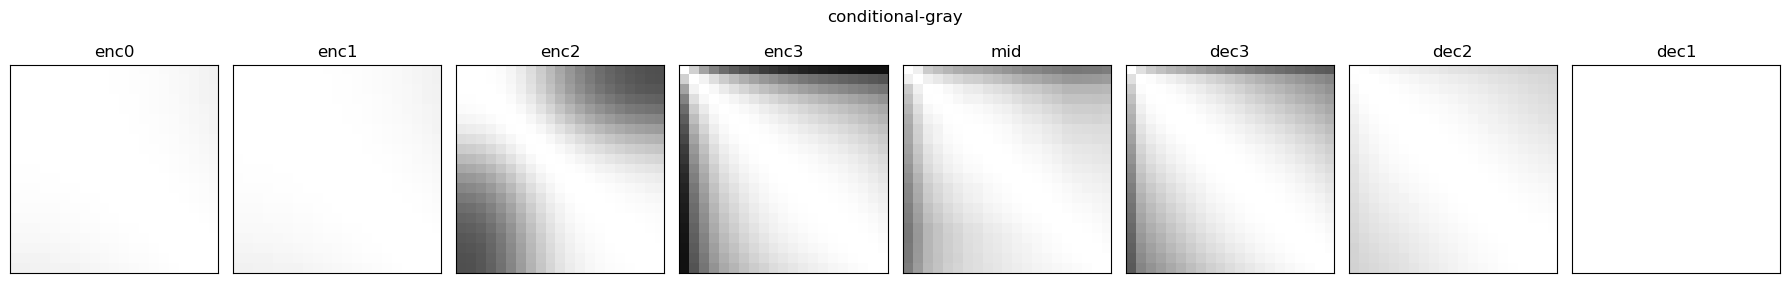

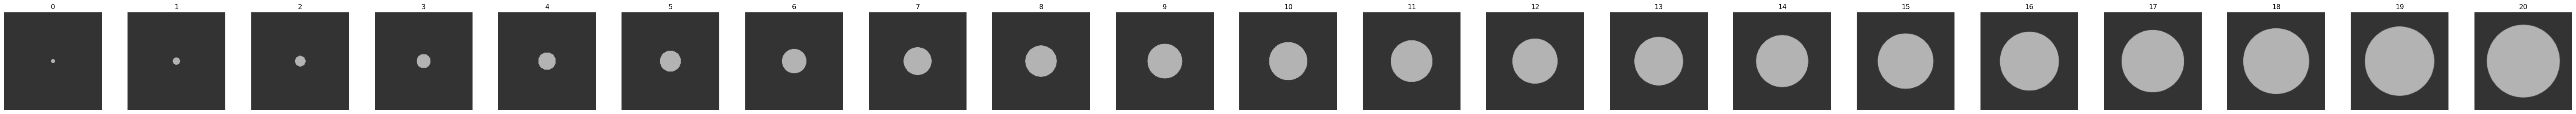

In [15]:
plot_phi_corr(interpolated_conditioner('oval_size', n= 21 ) , sig=0)

In [65]:
n_samples = 9

average_phi = False
fixed_h = True
sig_L=.1
h0=.05
beta=.05
# group = 'C'
seed = 0
freq =100
all_samples = {}
all_init = {}

param = 'oval_size' 
im_cond= interpolated_conditioner(param, n= 5 )

for i in range(len(im_cond)):
    print('---------- ', i)
    x_c = im_cond[i:i+1]

    if seed is not None: 
        torch.manual_seed(seed)
    init_im = .5 +torch.randn(n_samples,n_channels,K,K, device = device).to(device)
    sample, interm_Ys,sigmas, _ = batch_conditional_synthesis(denoisers['mixture-modified-gray'], 
                                                            x_c = x_c.to(device), 
                                                            average_phi=average_phi ,
                                                            init_im =init_im,
                                                            sig_0=1, 
                                                            sig_L=sig_L, 
                                                            h0=h0 , 
                                                            beta=beta , 
                                                            freq=freq,
                                                            device=device, 
                                                            fixed_h = fixed_h,
                                                            max_T=10000, 
                                                            seed=seed, 
                                                            output_size=(n_samples,n_channels,K,K))
    
    all_samples[i] = sample.detach()


----------  0
----------------------------- 100
sigma  0.7817585468292236
mean  0.4968624413013458
----------------------------- 200
sigma  0.608909547328949
mean  0.5063623189926147
----------------------------- 300
sigma  0.47912970185279846
mean  0.5034807920455933
----------------------------- 400
sigma  0.37103477120399475
mean  0.504456102848053
----------------------------- 500
sigma  0.28910160064697266
mean  0.5067194700241089
----------------------------- 600
sigma  0.22515031695365906
mean  0.5054540634155273
----------------------------- 700
sigma  0.1738004982471466
mean  0.5031396150588989
----------------------------- 800
sigma  0.13544248044490814
mean  0.5030767917633057
----------------------------- 900
sigma  0.10545959323644638
mean  0.502683162689209
-------- total number of iterations:  952
-------- final sigma,  0.09991157054901123
-------- final mean  0.5026634931564331
-------- final snr,  0.8296526223421097
----------  1
----------------------------- 100
sigma

height average_phi:  False fixed_h:  True sig_L 0.1 h0:  0.05 beta:  0.05 seed:  0


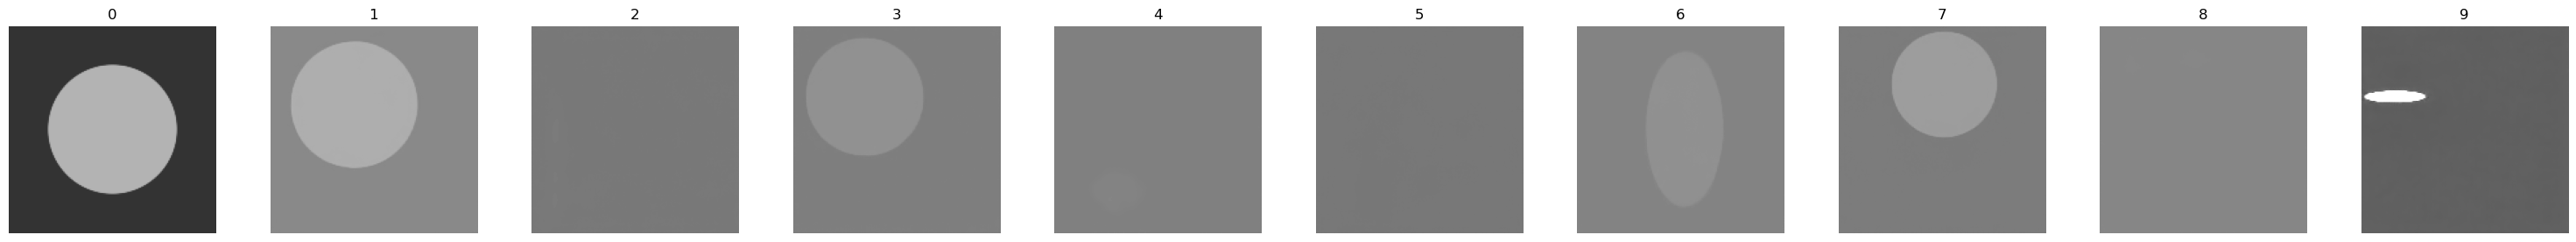

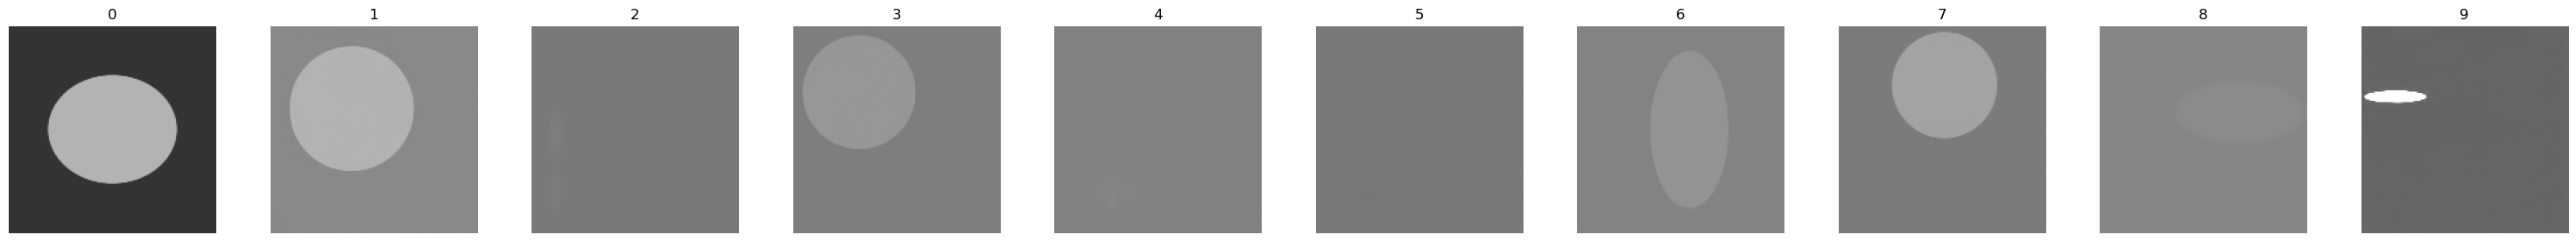

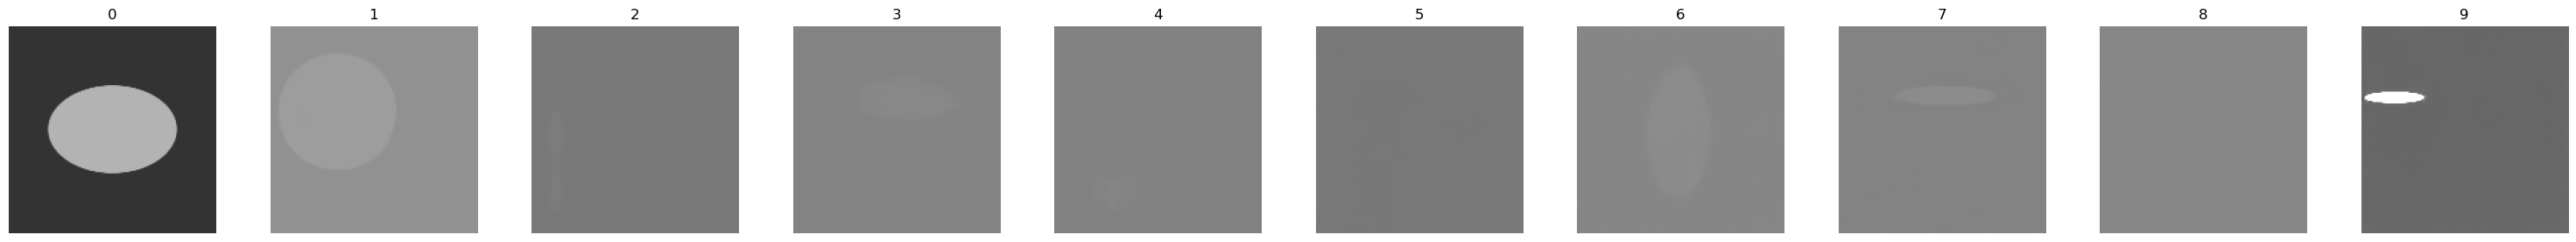

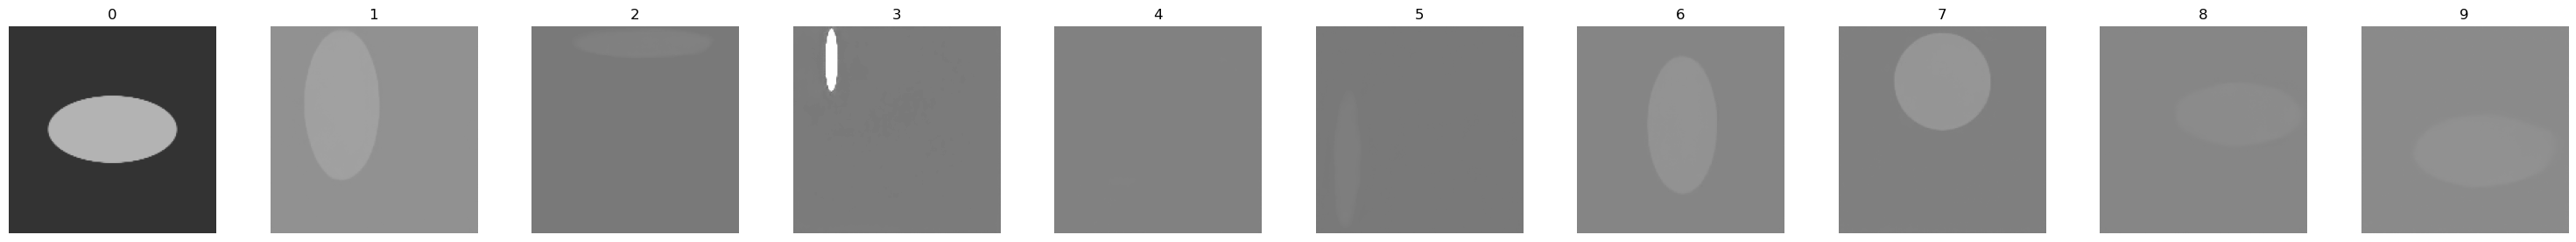

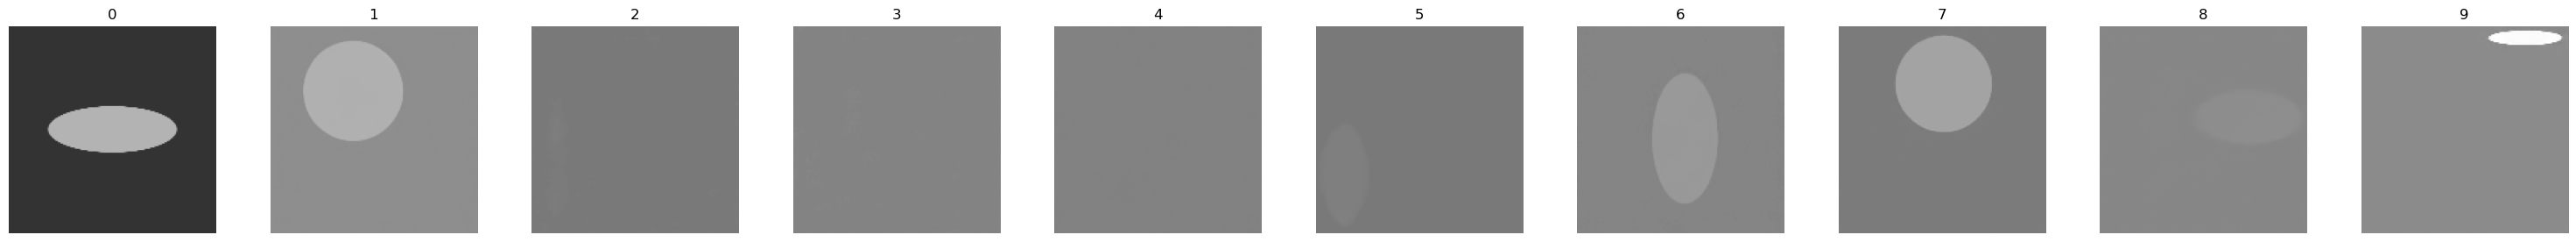

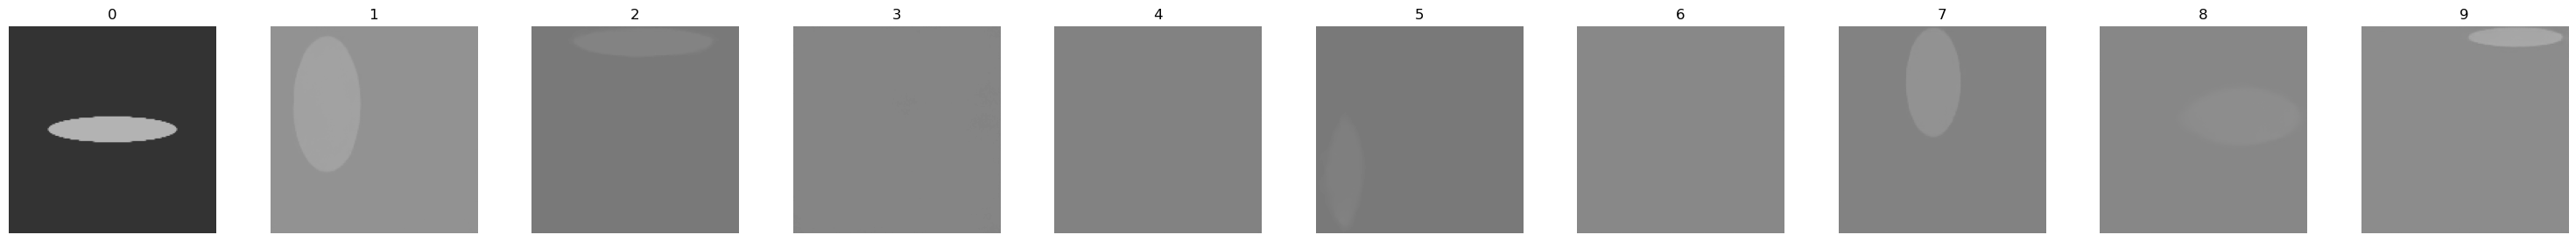

In [44]:
print( param, 'average_phi: ', average_phi , 'fixed_h: ',fixed_h, 'sig_L' ,sig_L,  'h0: ', h0 ,'beta: ' ,beta, 'seed: ', seed  )
for i in range(len(all_samples)):
    show_im_set(torch.concatenate([im_cond.cpu()[i:i+1],all_samples[i].detach().cpu()]), 
                n_columns=10, vmin=0, vmax = 1)

width average_phi:  False fixed_h:  True sig_L 0.1 h0:  0.05 beta:  0.05 seed:  0


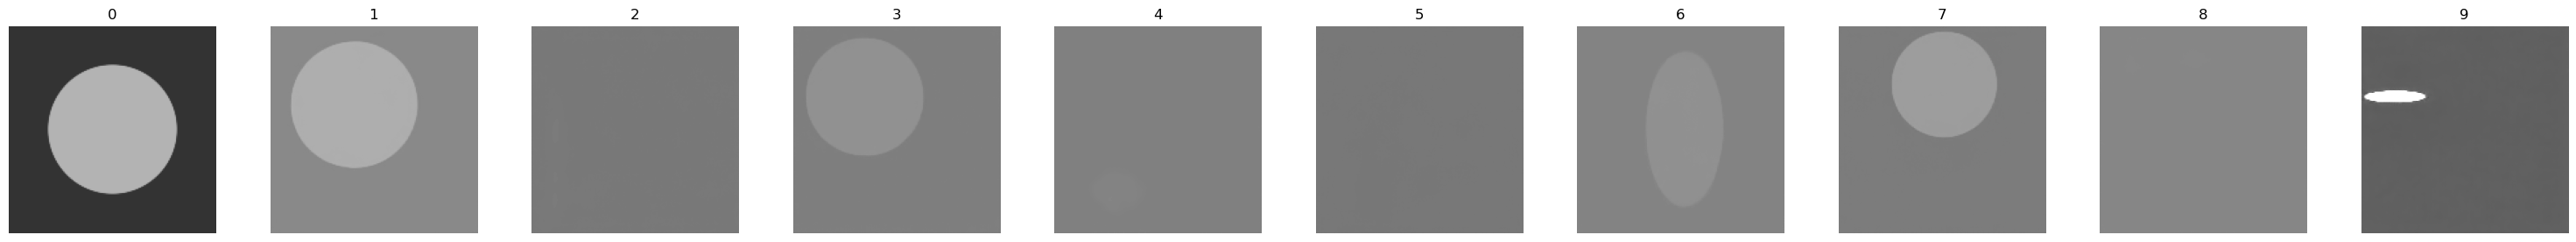

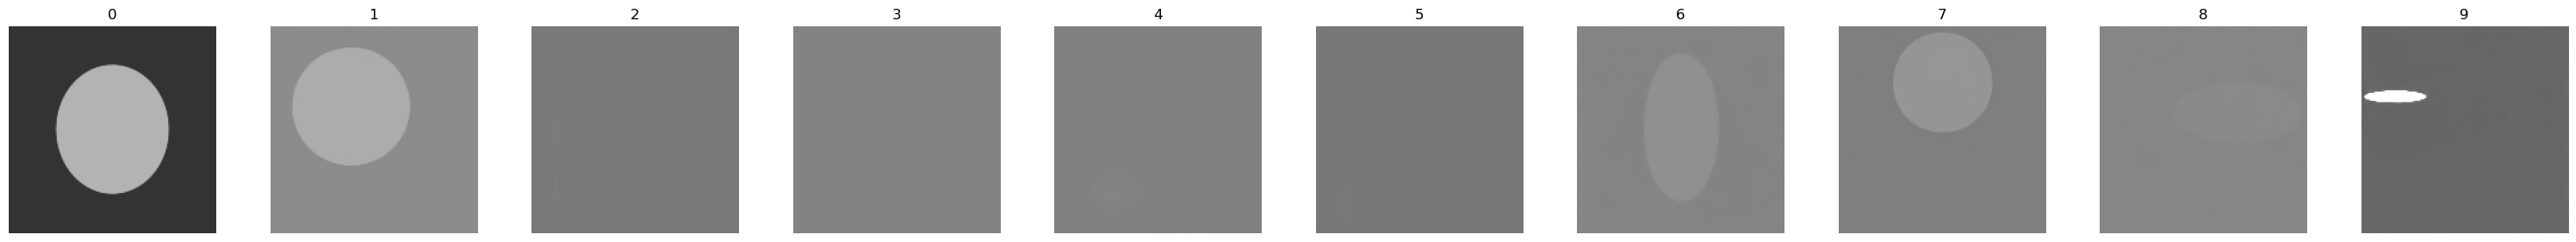

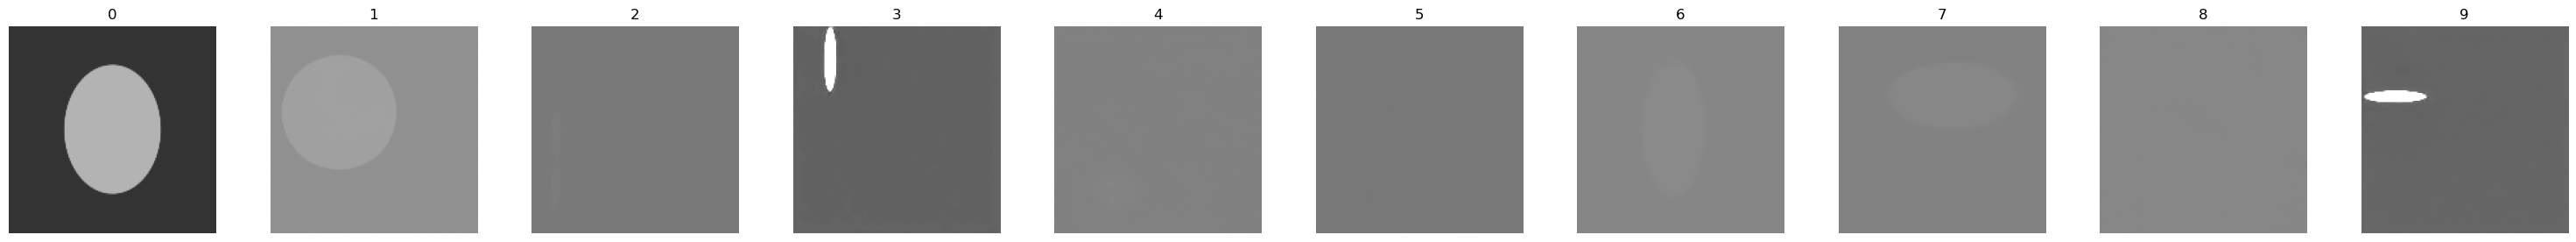

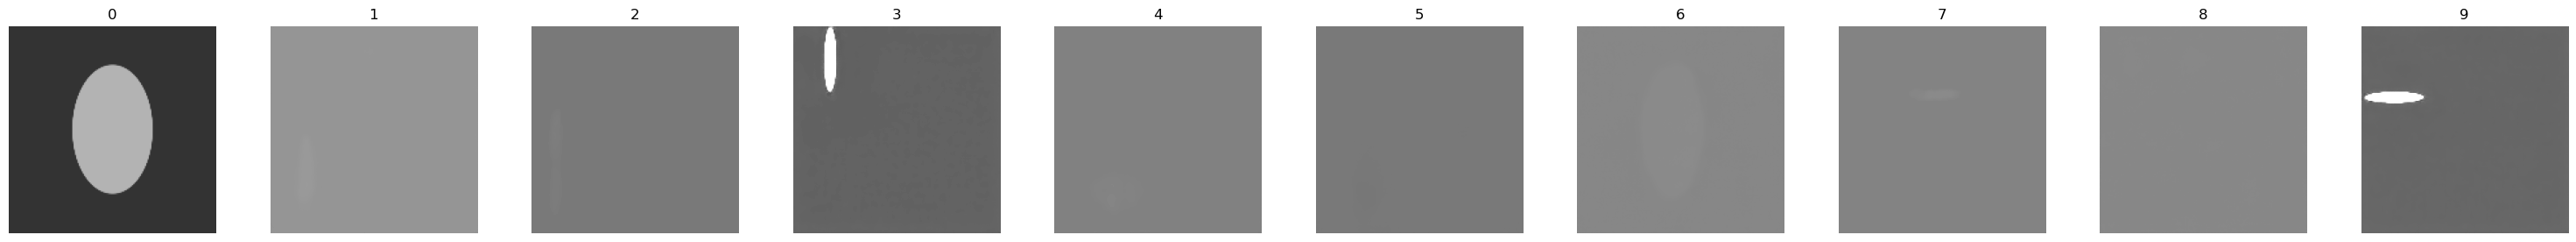

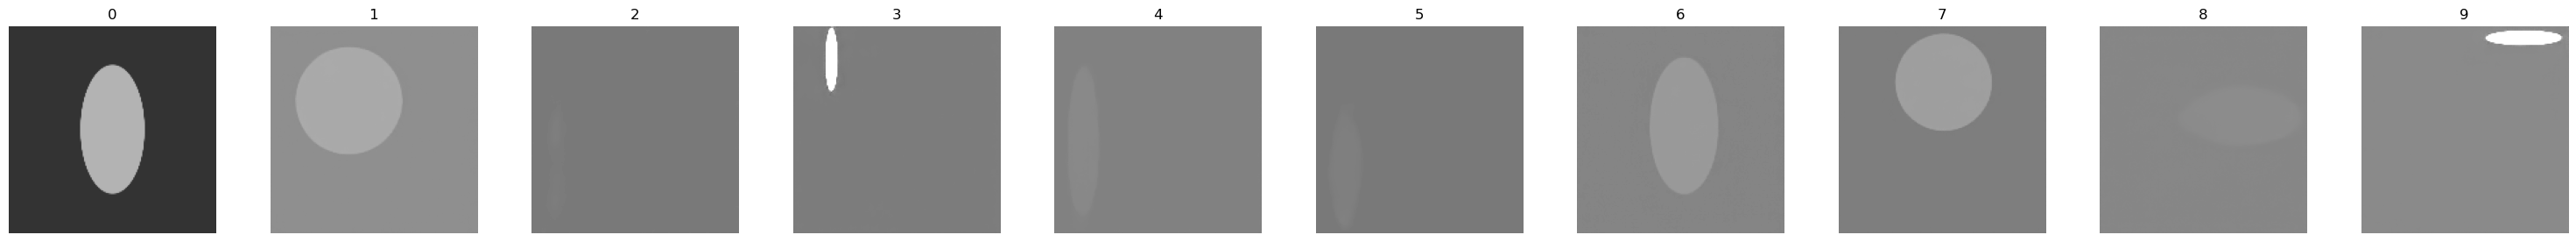

In [46]:
print( param, 'average_phi: ', average_phi , 'fixed_h: ',fixed_h, 'sig_L' ,sig_L,  'h0: ', h0 ,'beta: ' ,beta, 'seed: ', seed  )
for i in range(len(all_samples)):
    show_im_set(torch.concatenate([im_cond.cpu()[i:i+1],all_samples[i].detach().cpu()]), 
                n_columns=10, vmin=0, vmax = 1)

fg_intensity average_phi:  False fixed_h:  True sig_L 0.1 h0:  0.05 beta:  0.05 seed:  0


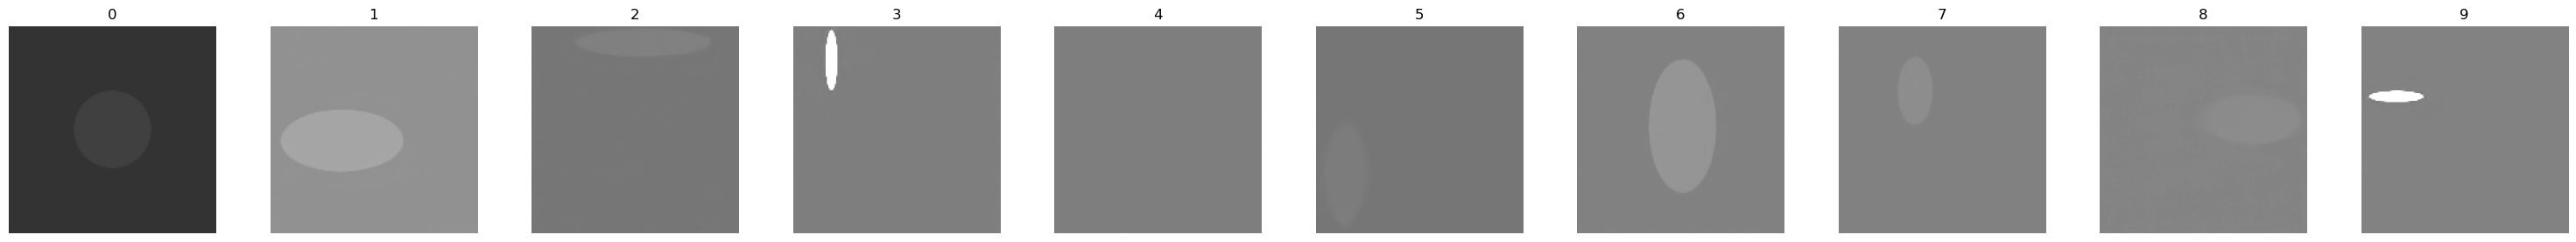

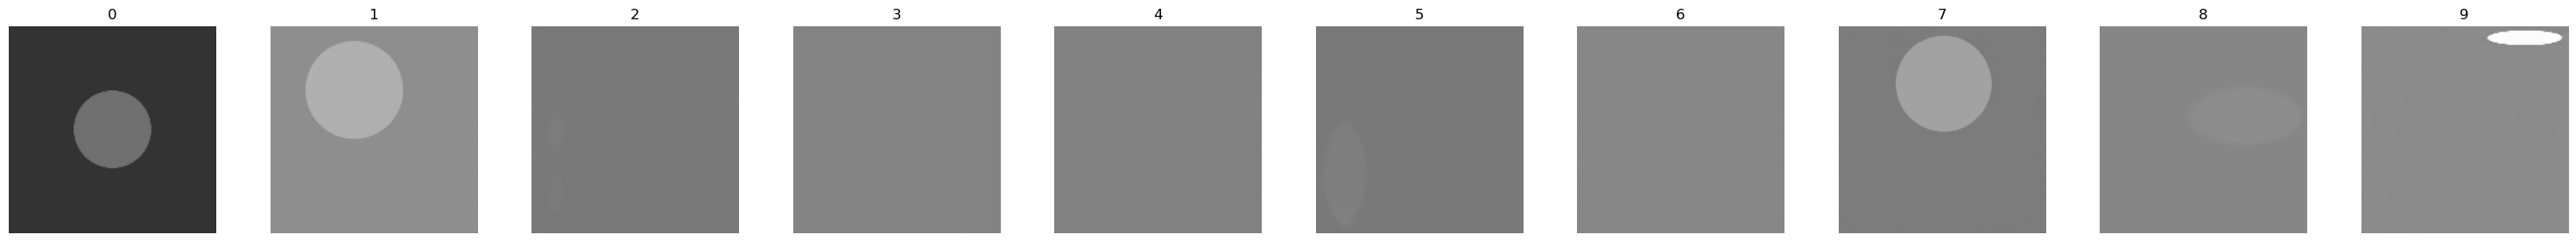

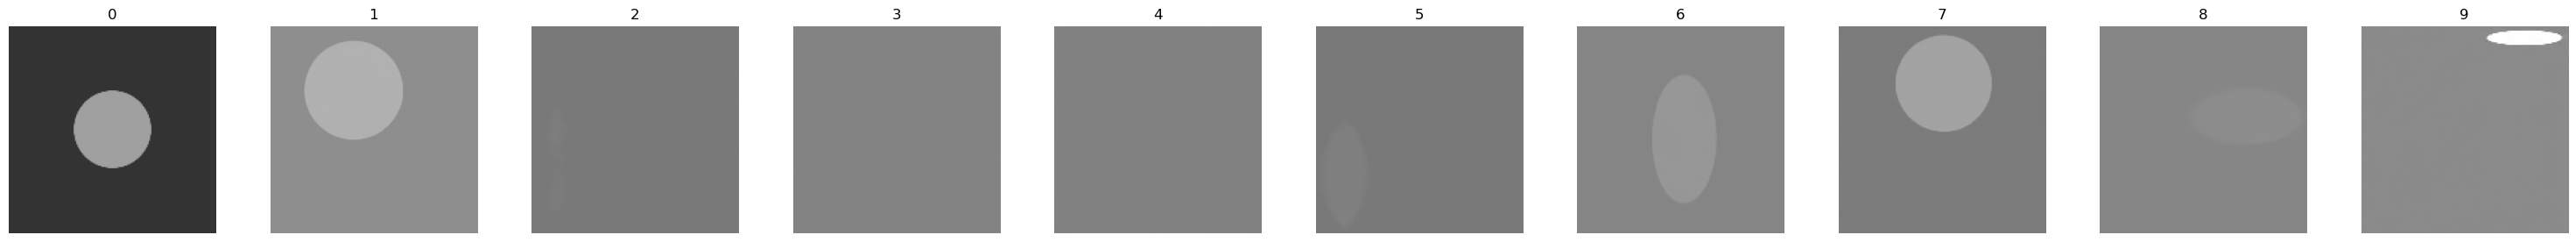

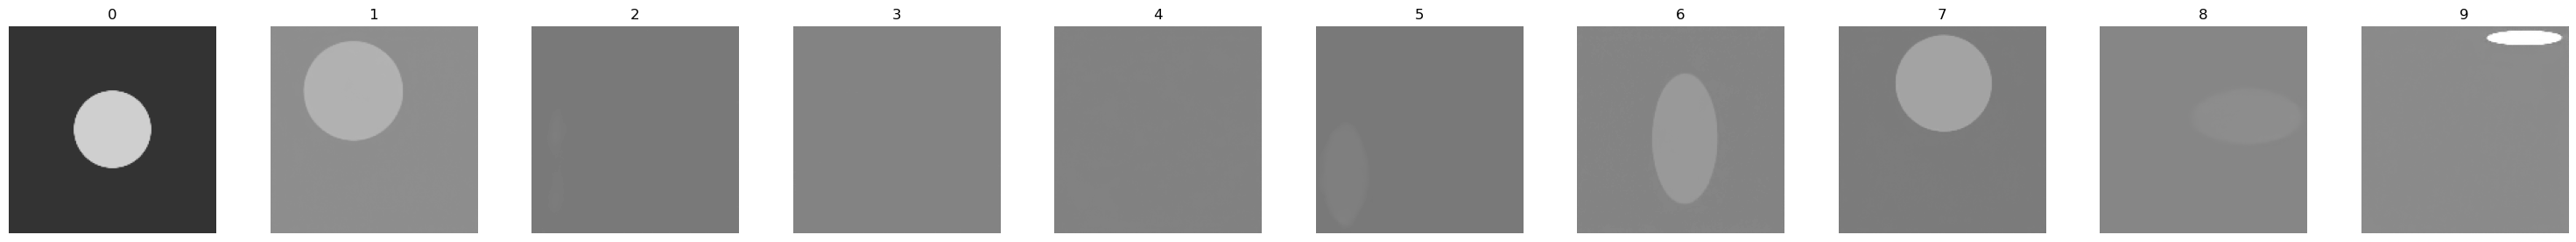

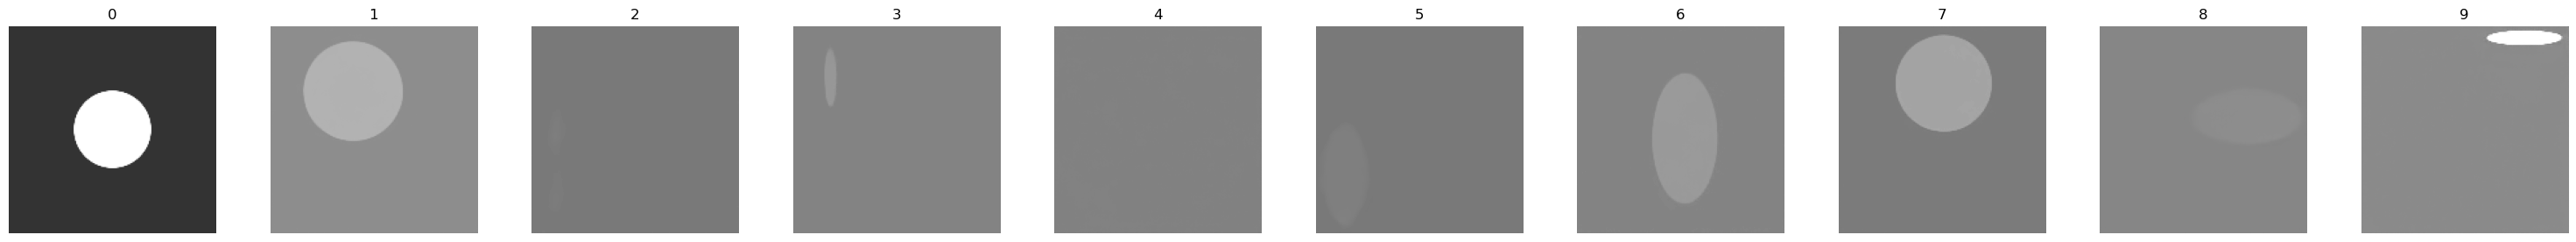

In [48]:
print( param, 'average_phi: ', average_phi , 'fixed_h: ',fixed_h, 'sig_L' ,sig_L,  'h0: ', h0 ,'beta: ' ,beta, 'seed: ', seed  )
for i in range(len(all_samples)):
    show_im_set(torch.concatenate([im_cond.cpu()[i:i+1],all_samples[i].detach().cpu()]), 
                n_columns=10, vmin=0, vmax = 1)

bg_intensity average_phi:  False fixed_h:  True sig_L 0.1 h0:  0.05 beta:  0.05 seed:  0


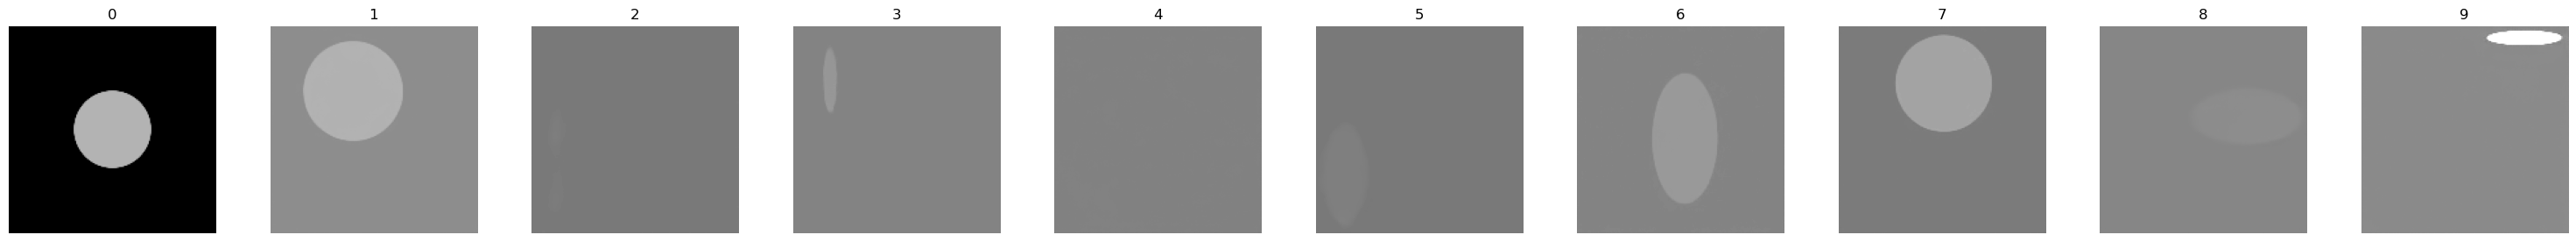

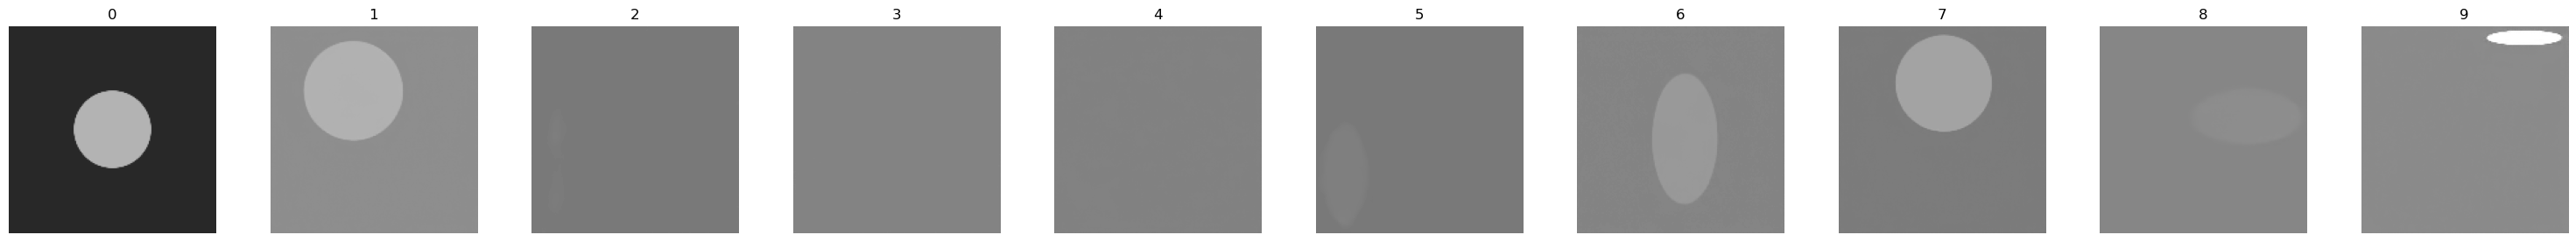

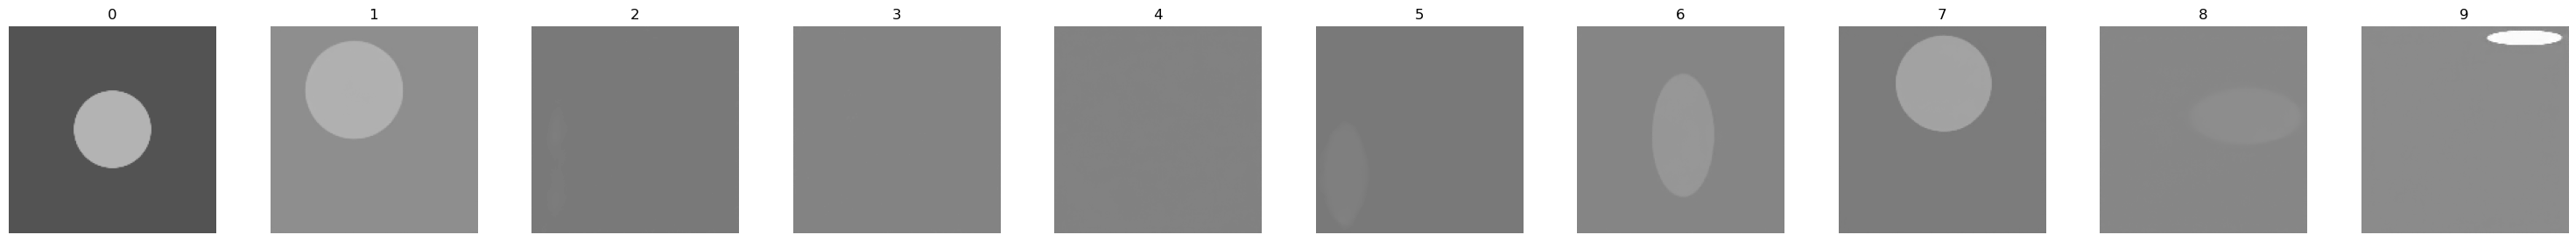

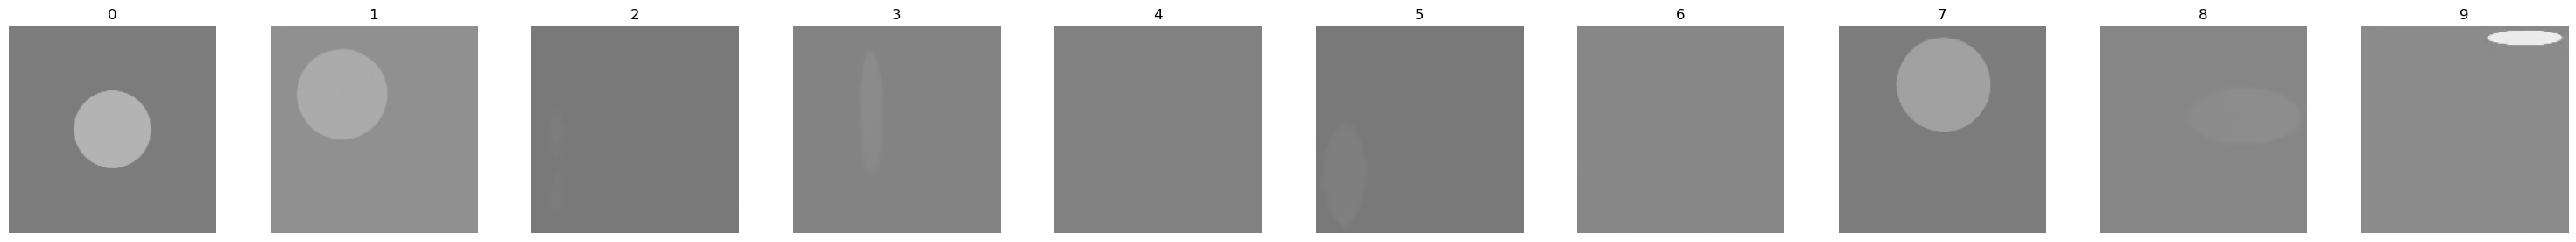

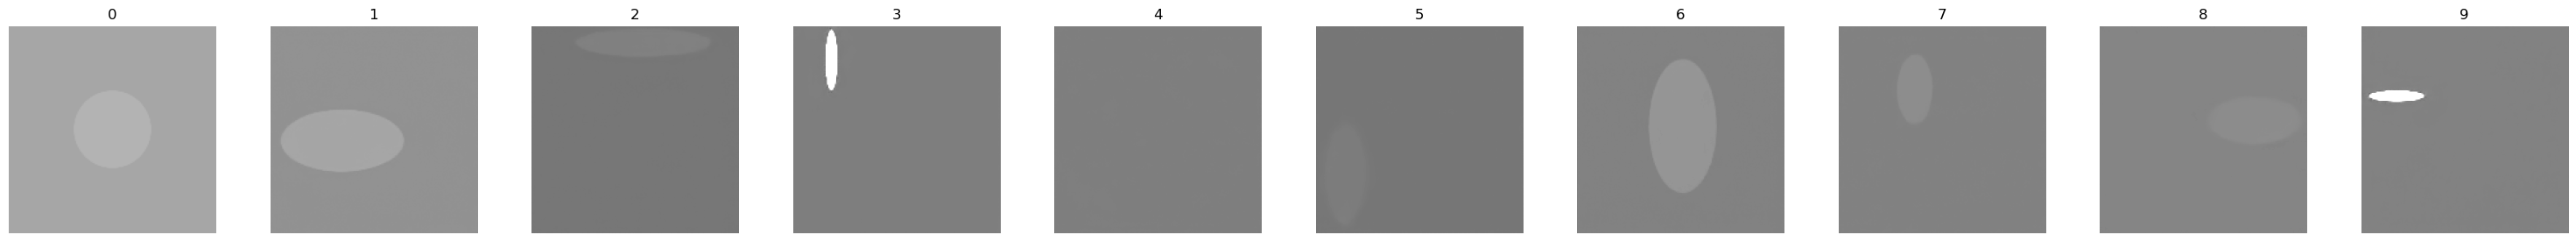

In [50]:
print( param, 'average_phi: ', average_phi , 'fixed_h: ',fixed_h, 'sig_L' ,sig_L,  'h0: ', h0 ,'beta: ' ,beta, 'seed: ', seed  )
for i in range(len(all_samples)):
    show_im_set(torch.concatenate([im_cond.cpu()[i:i+1],all_samples[i].detach().cpu()]), 
                n_columns=10, vmin=0, vmax = 1)

fg_bg_intensities average_phi:  False fixed_h:  True sig_L 0.1 h0:  0.05 beta:  0.05 seed:  0


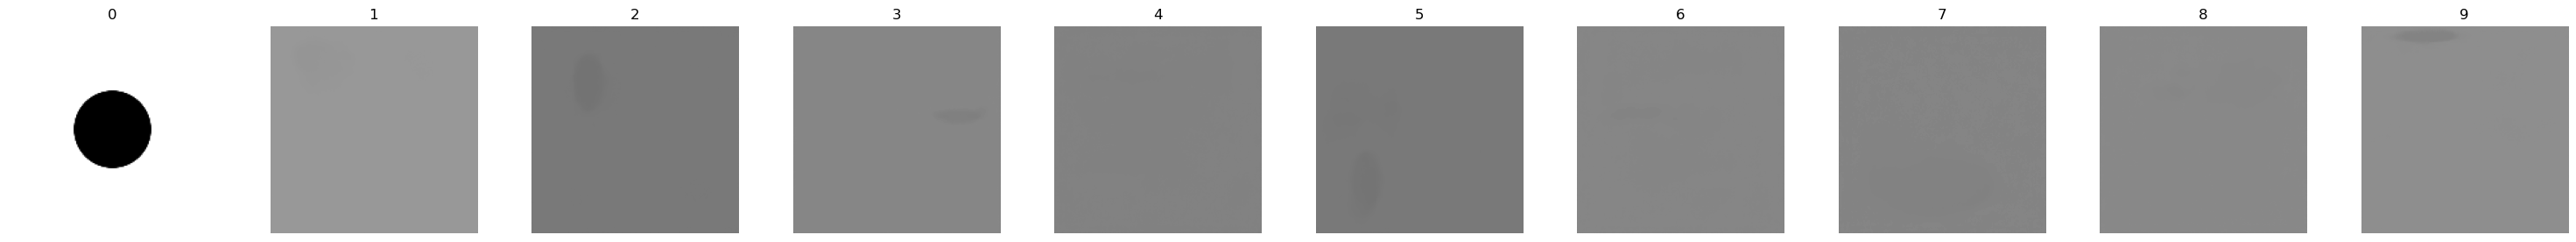

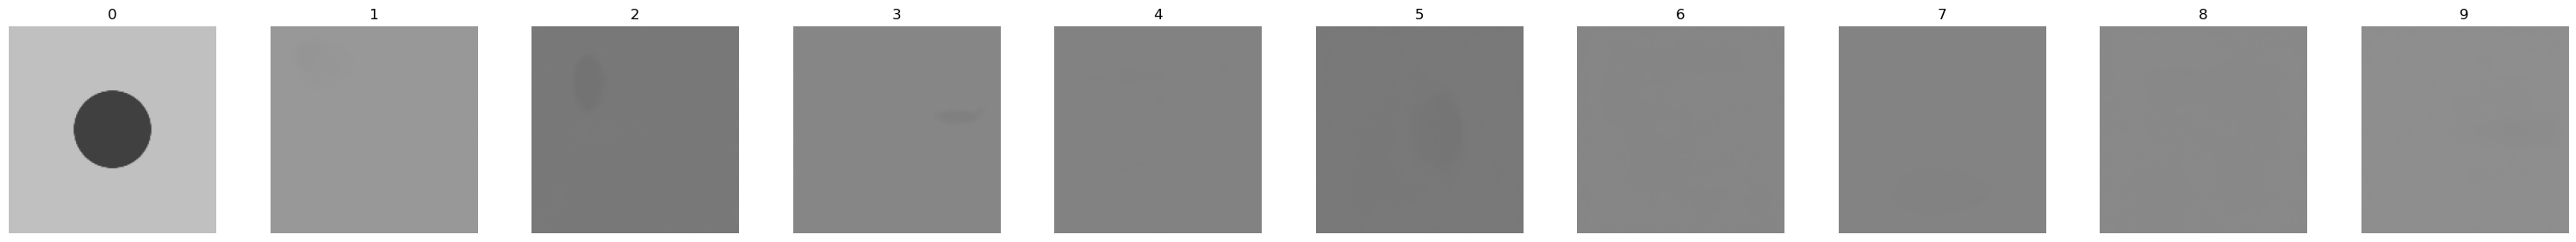

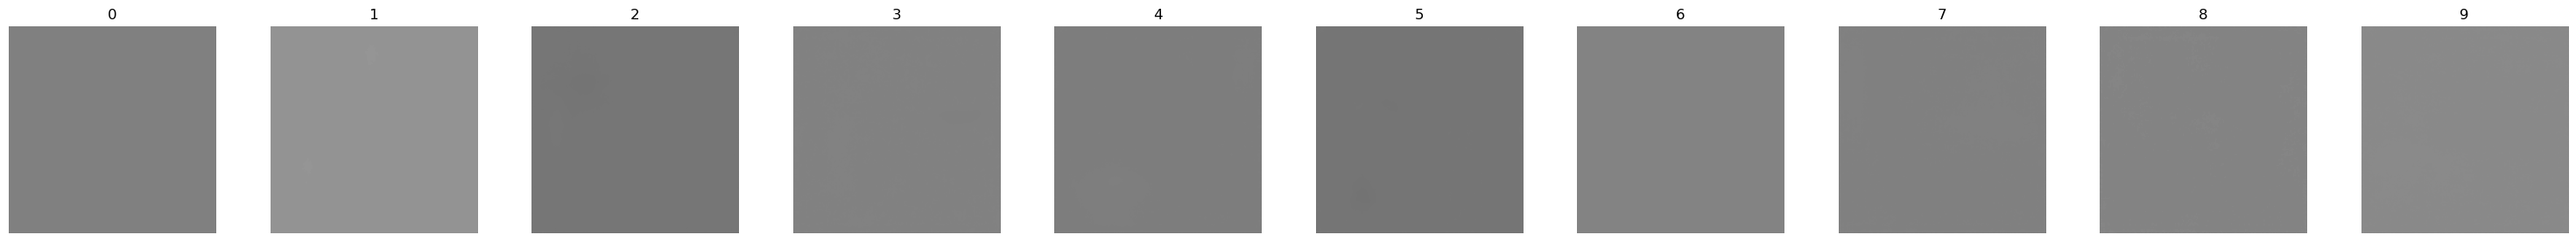

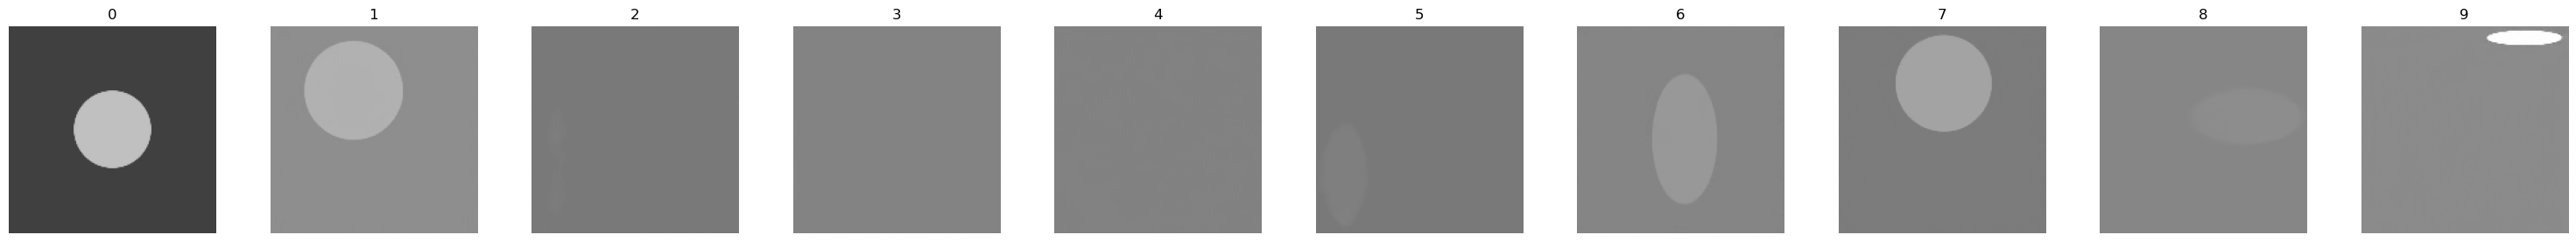

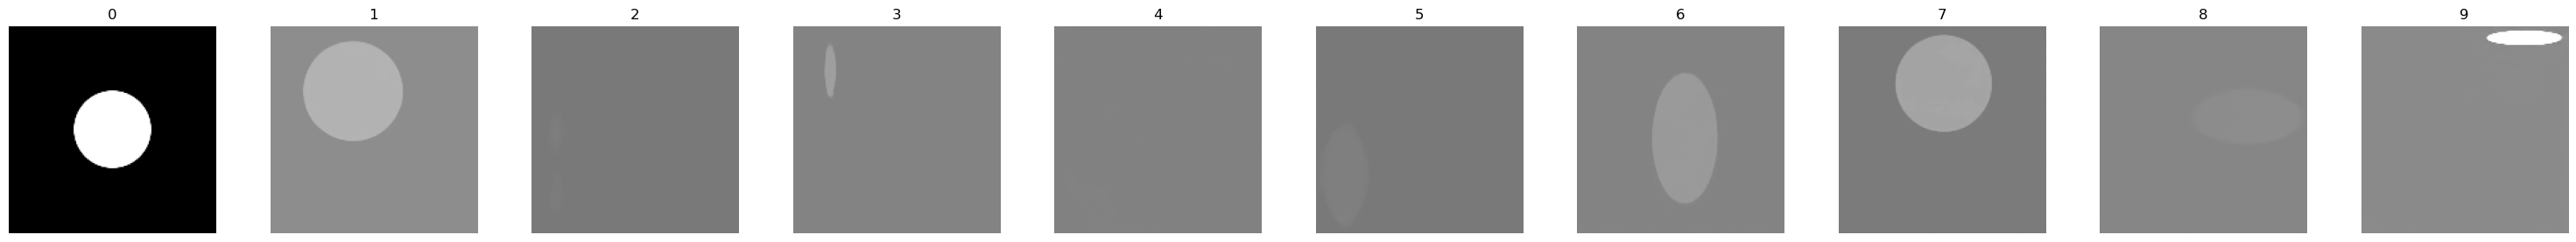

In [52]:
print( param, 'average_phi: ', average_phi , 'fixed_h: ',fixed_h, 'sig_L' ,sig_L,  'h0: ', h0 ,'beta: ' ,beta, 'seed: ', seed  )
for i in range(len(all_samples)):
    show_im_set(torch.concatenate([im_cond.cpu()[i:i+1],all_samples[i].detach().cpu()]), 
                n_columns=10, vmin=0, vmax = 1)

aspect_ratio average_phi:  False fixed_h:  True sig_L 0.1 h0:  0.05 beta:  0.05 seed:  0


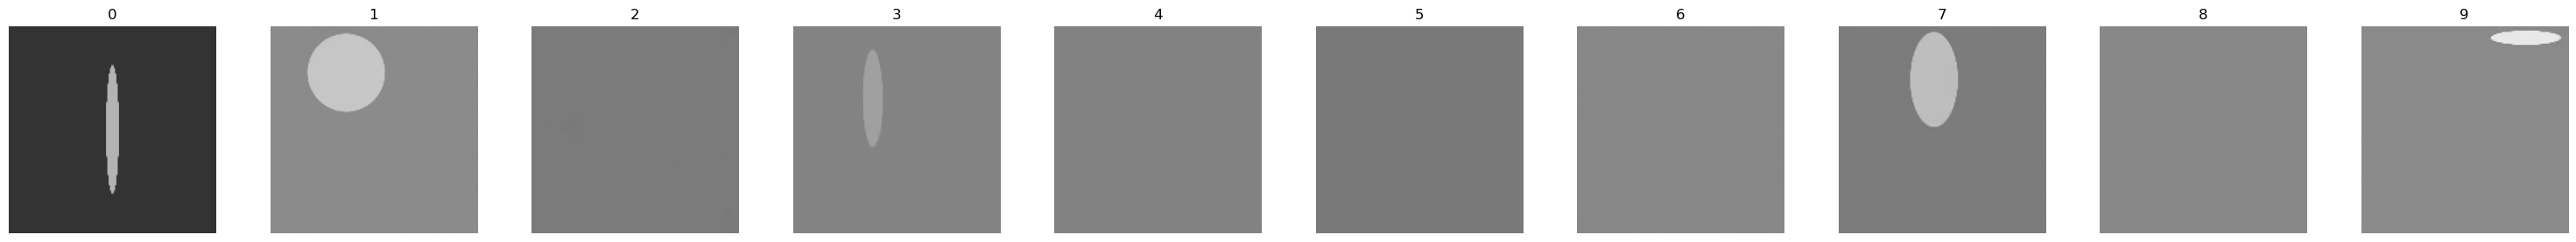

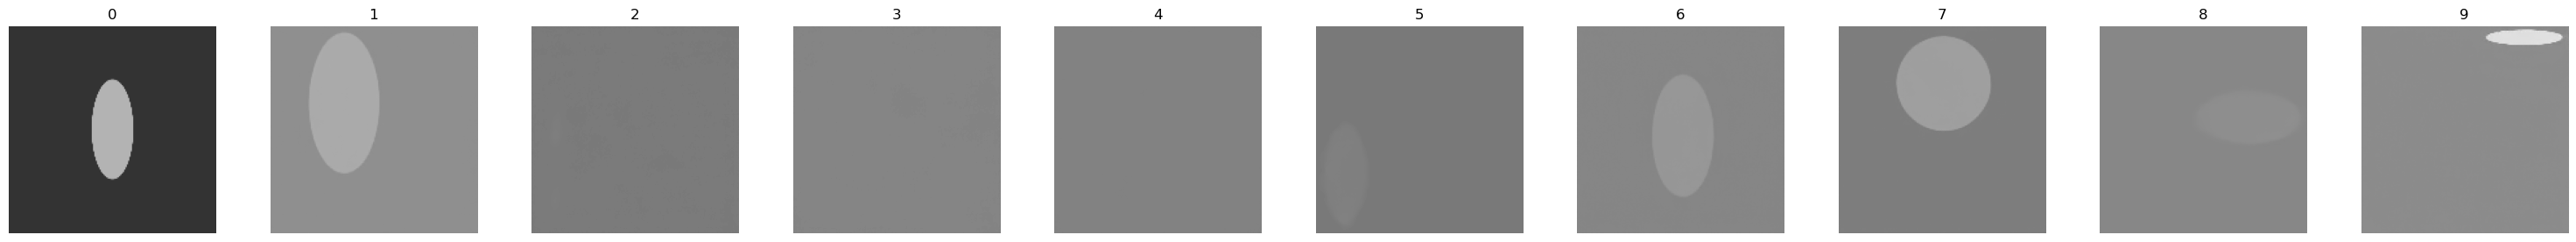

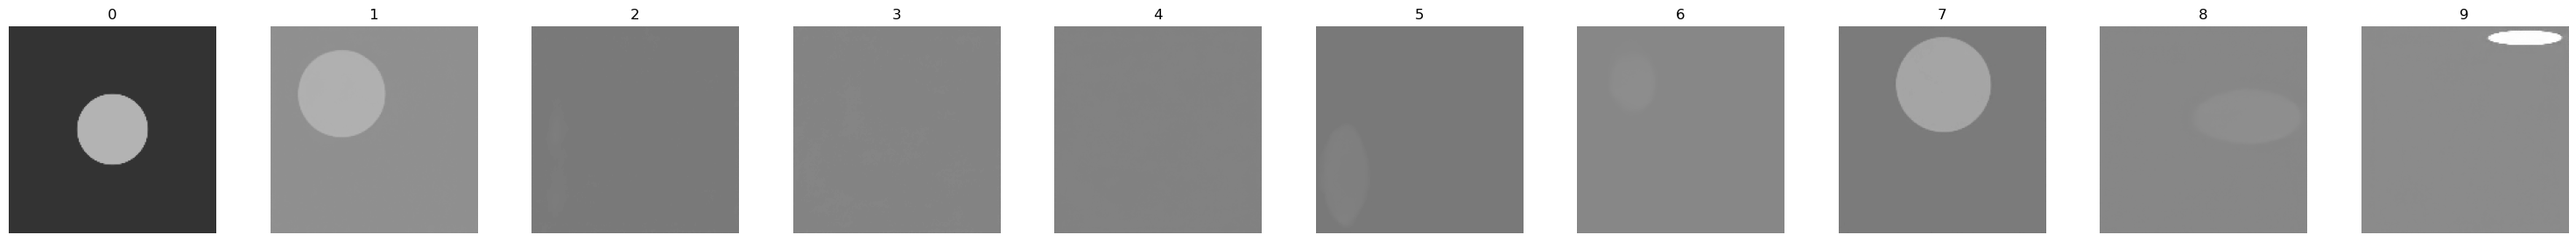

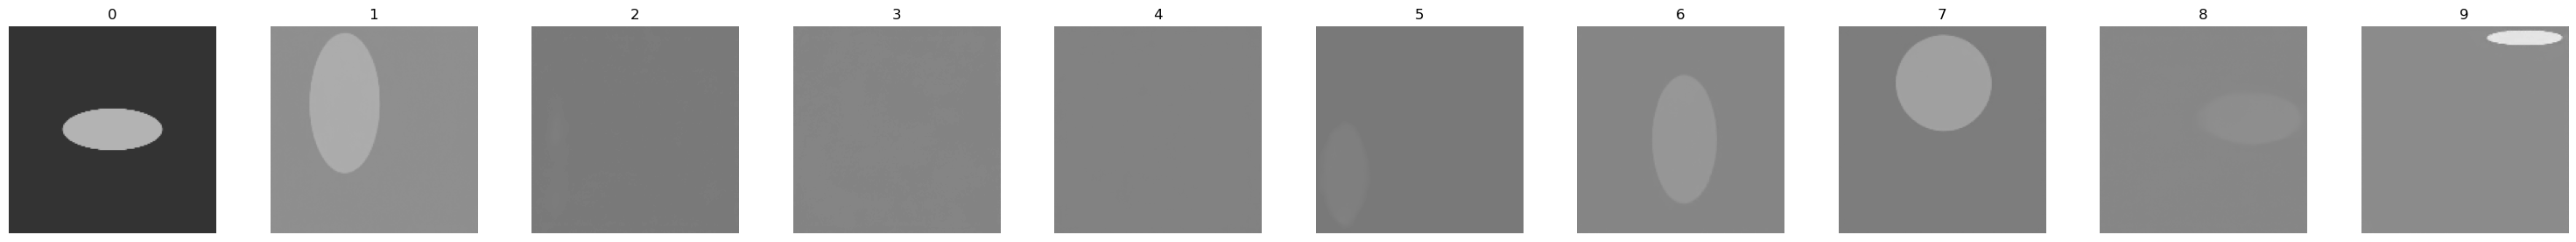

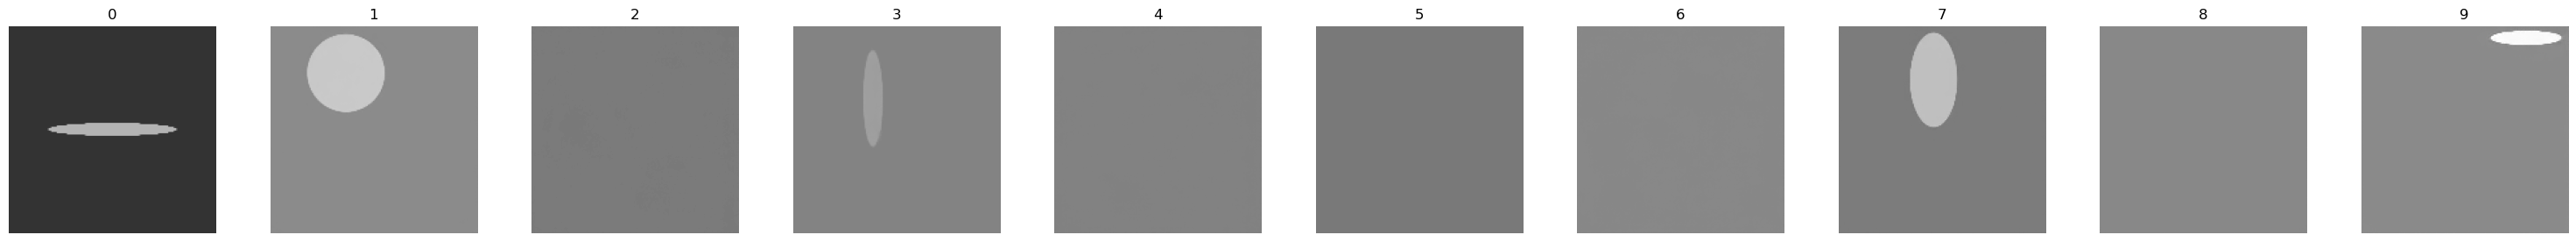

In [56]:
print( param, 'average_phi: ', average_phi , 'fixed_h: ',fixed_h, 'sig_L' ,sig_L,  'h0: ', h0 ,'beta: ' ,beta, 'seed: ', seed  )
for i in range(len(all_samples)):
    show_im_set(torch.concatenate([im_cond.cpu()[i:i+1],all_samples[i].detach().cpu()]), 
                n_columns=10, vmin=0, vmax = 1)

oval_size average_phi:  False fixed_h:  True sig_L 0.1 h0:  0.05 beta:  0.05 seed:  0


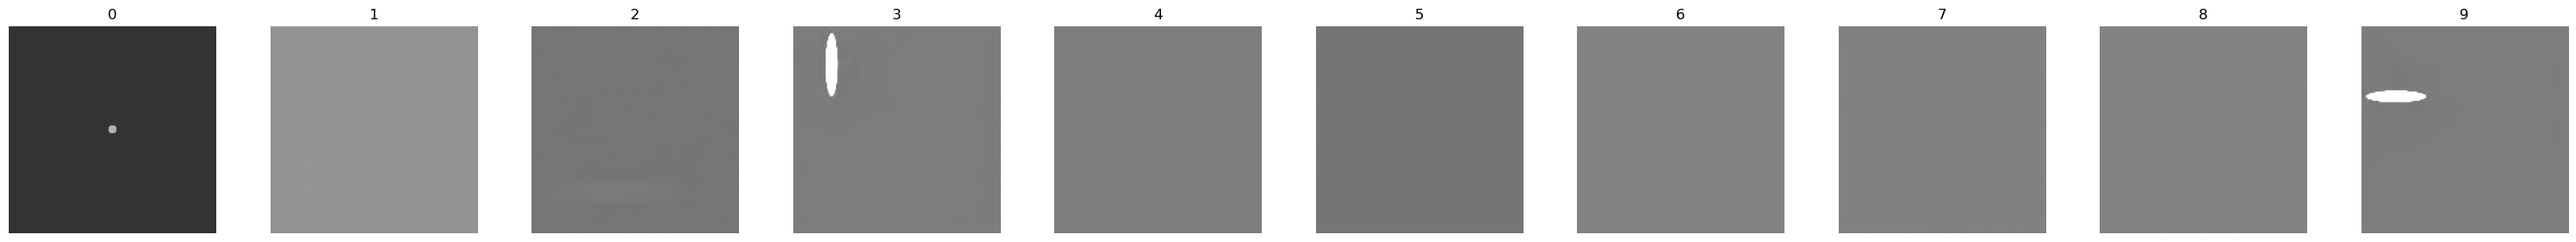

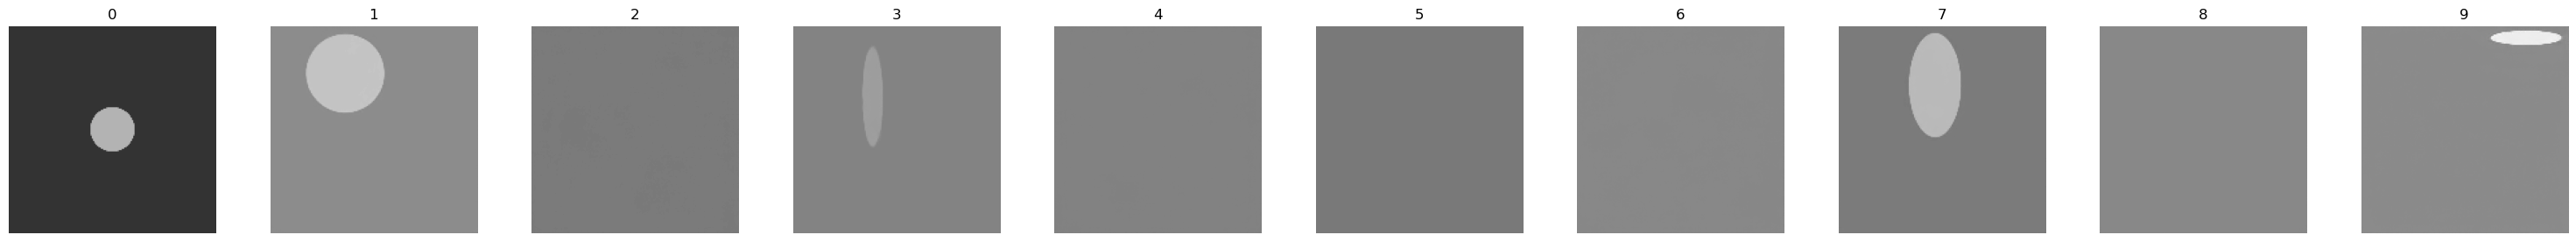

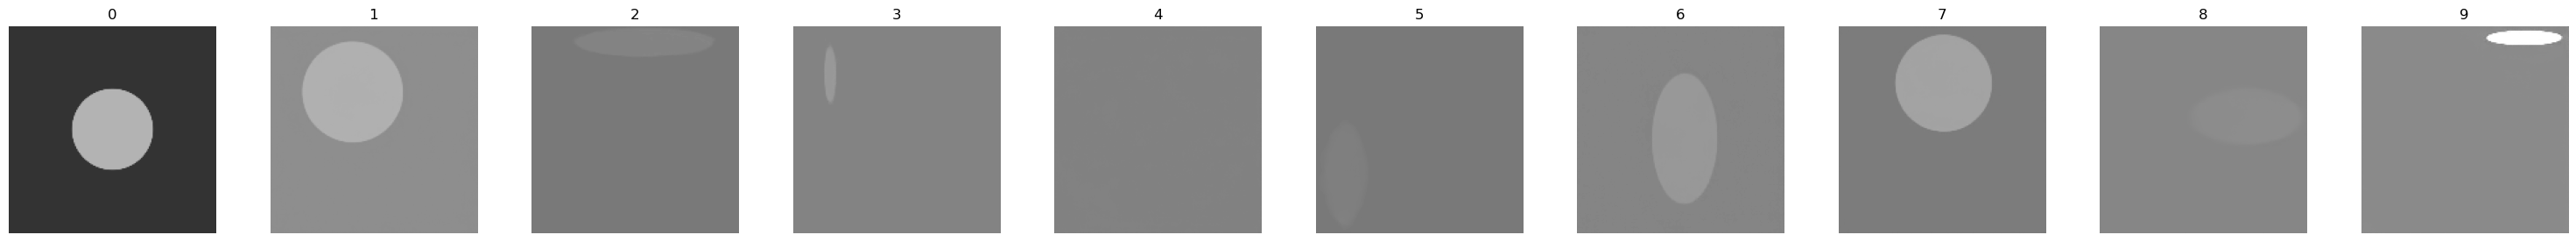

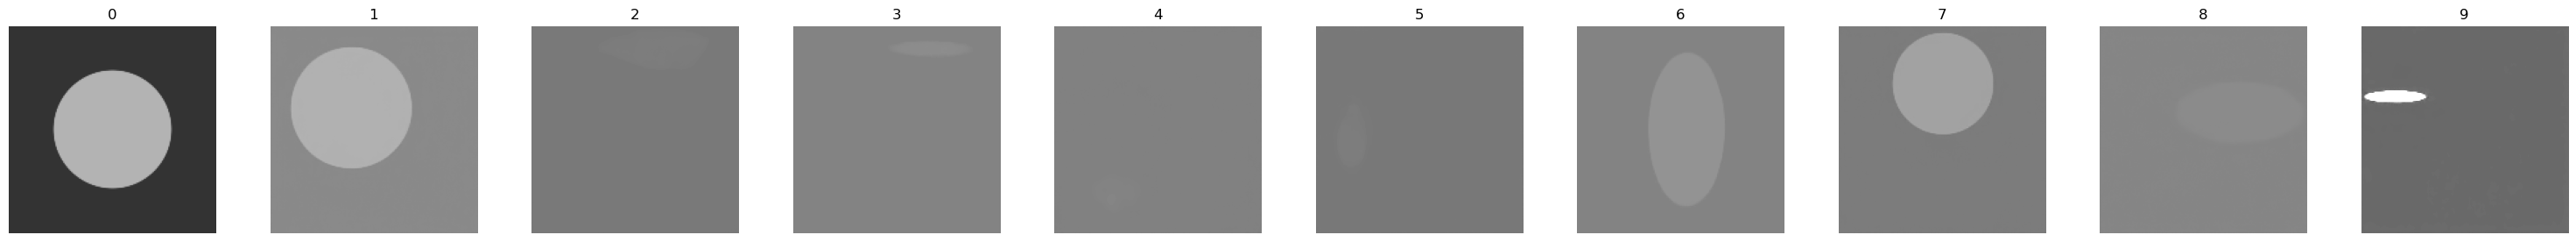

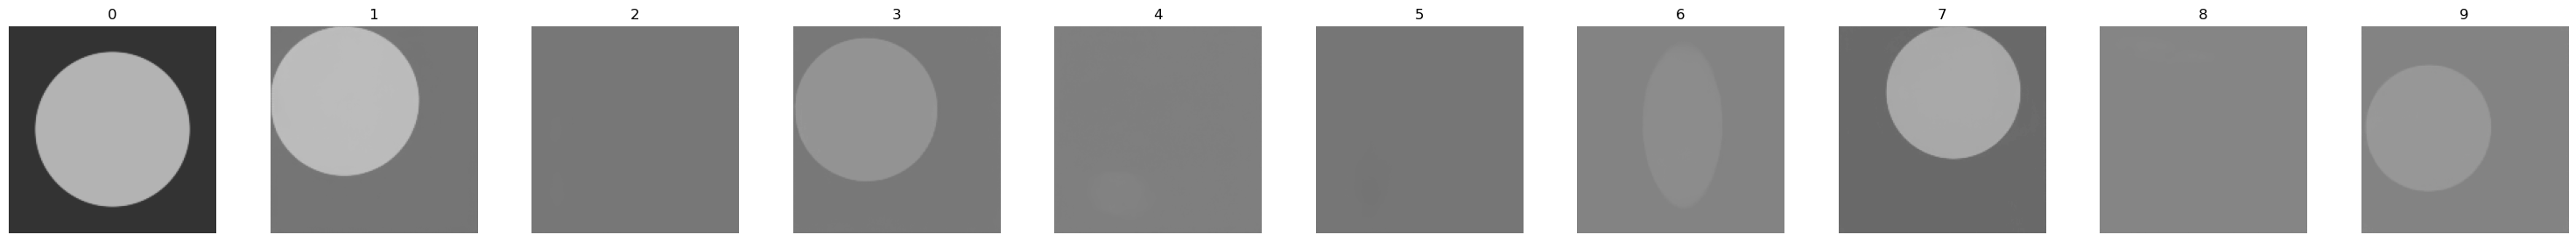

In [54]:
print( param, 'average_phi: ', average_phi , 'fixed_h: ',fixed_h, 'sig_L' ,sig_L,  'h0: ', h0 ,'beta: ' ,beta, 'seed: ', seed  )
for i in range(len(all_samples)):
    show_im_set(torch.concatenate([im_cond.cpu()[i:i+1],all_samples[i].detach().cpu()]), 
                n_columns=10, vmin=0, vmax = 1)

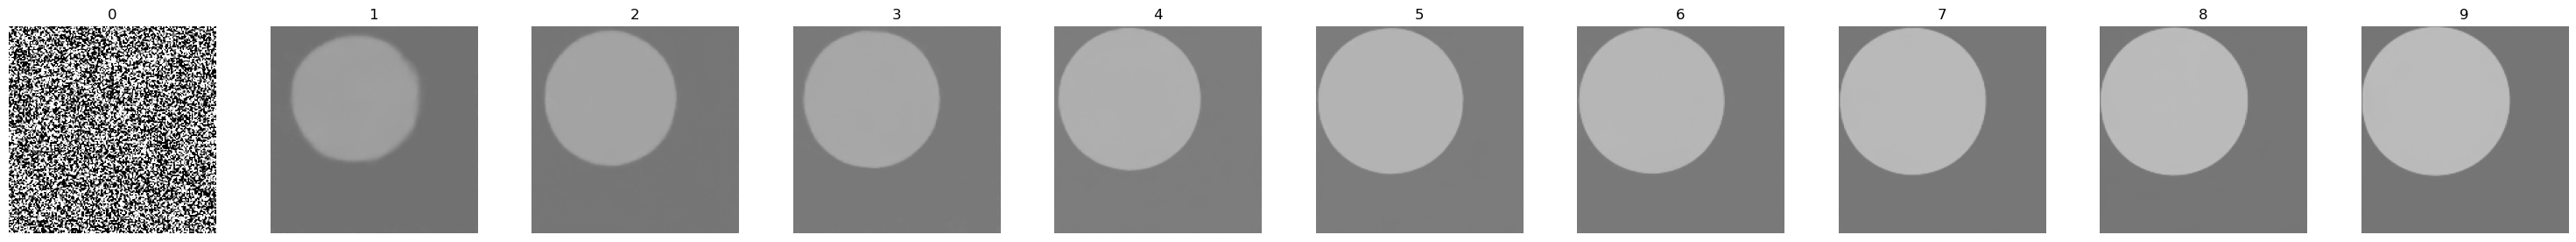

In [84]:
show_im_set(torch.stack(interm_Ys)[:,0], n_columns=10,vmin=0, vmax = 1)
